In [23]:
import os
import pandas
import itertools
import nibabel as ni
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from statsmodels.sandbox.stats.multicomp import multipletests
from nilearn import image, input_data, plotting
from mpl_toolkits.mplot3d import Axes3D
import plotly

In [42]:
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = round(int((origin[0]-x)*vs))
        y = round(int((y-origin[1])*vs))
        z = round(int((z-origin[2])*vs))
        
    elif to_what == 'xyz':
        x=round(int(origin[0]- x/vs))
        y=round(int(y/vs + origin[1]))
        z=round(int(z/vs + origin[2]))
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

In [3]:
def ABA_average_expression_from_atlas(ABA_dir, atlas, sheet_name = 'MicroarrayExpression.csv', 
                                      has_header = False, has_index = False, save=False, 
                                      average = False, save_coords = False, outlab = ''):
    
    ABA_subs = sorted(glob(os.path.join(ABA_dir,'normalized_microarray_donor*')))
    final_out = {}
    print('preparing image...')
    atl = ni.load(atlas).get_data()
    if average:
        outnm = 'avg'
    else:
        outnm = 'all'
    if save_coords:
        cdf = pandas.DataFrame(columns = ['sub','label','x','y','z'])
    cnt=0
    for sdir in ABA_subs:
        sid = os.path.split(sdir)[-1].split('donor')[-1]
        print('working on subject',sid)
        print('loading data...')
        coords = pandas.read_csv(os.path.join(sdir,'SampleAnnot.csv'))
        if has_header and has_index:
            data = pandas.read_csv(os.path.join(sdir,sheet_name))
        elif has_index and not has_header:
            data = pandas.read_csv(os.path.join(sdir,sheet_name),header=None)
        elif has_header and not has_index:
            data = pandas.read_csv(os.path.join(sdir,sheet_name),index_col=0)
        else:
            data = pandas.read_csv(os.path.join(sdir,sheet_name),index_col=0, header=None)
        output = pandas.DataFrame(index = data.index)
        for lab in np.unique(atl)[1:]:
            print('searching for probes in label',lab)
            hits_idx = {}
            for i in coords.index:
                mni_cs = coords.loc[i][['mni_x','mni_y','mni_z']]
                x,y,z = convert_coords(mni_cs, to_what = 'xyz')
                x,y,z = int(round(x)), int(round(y)), int(round(z))
                if atl[x,y,z] == lab:
                    hits_idx.update({i: (x,y,z)})
                    if save_coords:
                        cdf.loc[cnt,'sub'] = sid
                        cdf.loc[cnt,'label'] = i
                        cdf.loc[cnt,'x'] = x
                        cdf.loc[cnt,'y'] = y
                        cdf.loc[cnt,'z'] = z
                    if not average:
                        output.loc[:,'lab_%s_samp_%s'%(lab,i)] = data.iloc[:,i]
                    cnt += 1
            print('found %s hits'%(len(hits_idx.keys())))
            if average:
                output.loc[:,'lab_%s'%lab] = data.iloc[:,list(hits_idx.keys())].mean(axis=1)
            
                    
        print('finishing up subject',sid)
        final_out.update({sid: output})
        if save:
            output.to_csv(os.path.join(ABA_dir,'%s_%s_%s_expression_data.csv'%(outlab,
                                                                               sid,
                                                                               outnm)))
            
    if save_coords:
        cdf.to_csv(os.path.join(ABA_dir,'%s_hit_coordinates.csv'%outlab))
        
    return final_out

In [ ]:
def img_v_expression_analysis(imgs, hits_idx, xp_dfs, coord_dfs, mask = None, 
                             has_header = False, has_index = False, save_dir = None, vs = 1):
    
    all_results = {}
    if type(mask) != type(None):
        msk = mask
    for s, sheet in enumerate(xp_dfs):
        print('initializing subject', s)
        if has_header and has_index:
            xpdf = pandas.read_csv(sheet)
        elif has_index and not has_header:
            xpdf = pandas.read_csv(sheet, header = None)
        elif has_header and not has_index:
            xpdf = pandas.read_csv(sheet, index_col = 0)
        else:
            xpdf = pandas.read_csv(sheet, header = None, index_col = 0)
        xpdf = xpdf.loc[hits_idx]
        if type(xpdf.iloc[0,0]) != float:
            xpdf.drop(xpdf.columns[0], axis=1, inplace = True)
            xpdf.columns = [str(x) for x in range(len(xpdf.columns))]
        cdf = pandas.read_csv(coord_dfs[s])
        for i,row in cdf.iterrows():
            x,y,z = convert_coords([row['mni_x'],row['mni_y'],row['mni_z']],to_what='xyz',vs=vs)
            cdf.loc[i,'x'] = x
            cdf.loc[i,'y'] = y
            cdf.loc[i,'z'] = z
    
        if type(mask) != type(None):
            print('cleaning coordinates')
            good_cs = []
            for samp in xpdf.columns:
                if msk[int(round(cdf.loc[int(samp),'x'])),
                      int(round(cdf.loc[int(samp),'y'])),
                      int(round(cdf.loc[int(samp),'z']))] == 1:
                    good_cs.append(samp)
            xpdf = xpdf[good_cs]
            rx = [int(round(x)) for x in cdf.loc[[int(c) for c in good_cs],'x']]
            ry = [int(round(x)) for x in cdf.loc[[int(c) for c in good_cs],'y']]
            rz = [int(round(x)) for x in cdf.loc[[int(c) for c in good_cs],'z']]
            idata = pandas.DataFrame(index = [int(c) for c in good_cs], 
                                     columns = range(len(imgs)))
        else:
            rx = [int(round(x)) for x in cdf.x]
            ry = [int(round(x)) for x in cdf.y]
            rz = [int(round(x)) for x in cdf.z]
            idata = pandas.DataFrame(index = cdf.index, columns = range(len(imgs)))
        
        print('extracting imaging data')
        for n,img in enumerate(imgs):
            dat = ni.load(img).get_data()
            idata.loc[:,n] = dat[rx,ry,rz]
        
        print('running associations')
        res = pandas.DataFrame(index = xpdf.index, columns = ['r','p'])
        for i in xpdf.index:
            res.loc[i,:] = stats.pearsonr(xpdf.loc[i],idata.mean(axis=1))
        res.loc[:,'Q_hs'] = multipletests(res.p)[1]
        res.loc[:,'Q_bh'] = multipletests(res.p, method = 'fdr_bh')[1]
        res.loc[:,'Q_bonf'] = multipletests(res.p, method = 'bonferroni')[1]
        
        if os.path.isdir(save_dir):
            print('saving results to', save_dir)
            res.to_csv(os.path.join(save_dir, 'subject_%s'%s))
        all_results.update({s: res})
    
    return all_results
        

### Get the data

In [51]:
df = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_hippocampus_sample_info.csv')
hxp = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_hippocampus_gxp.csv',
                     index_col = 0)

In [11]:
mni = ni.load('/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')
hipp_labs = ni.load('/home/users/jvogel/Science/templates/atlases/Lund/hippocampus_labels_LUND_scif55.nii.gz')
hipp = ni.load('/home/users/jvogel/Science/templates/masks/Hippocampus_maxprob_thr0_1mm.nii')

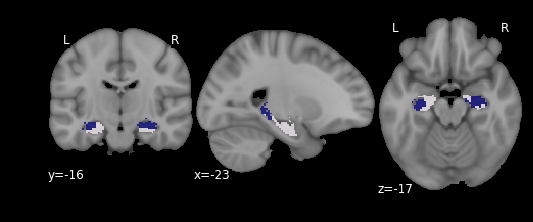

In [13]:
plt.close()
plotting.plot_roi(hipp_labs,mni, draw_cross=False)
plt.show()

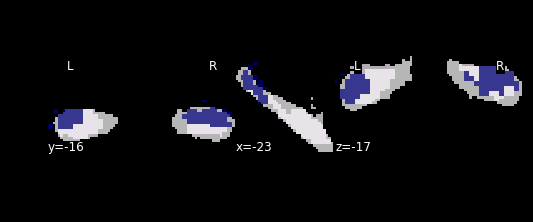

In [14]:
plt.close()
plotting.plot_roi(hipp_labs,hipp, draw_cross=False)
plt.show()

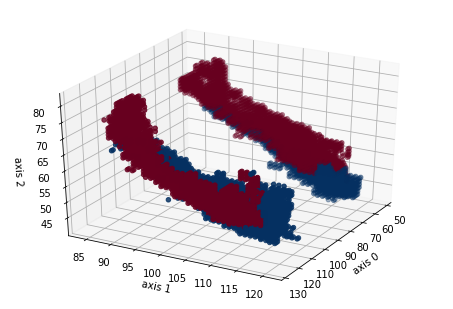

In [16]:
plt.close()
label_locations = np.where(hipp_labs.get_data() > 0)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = hipp_labs.get_data()[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()


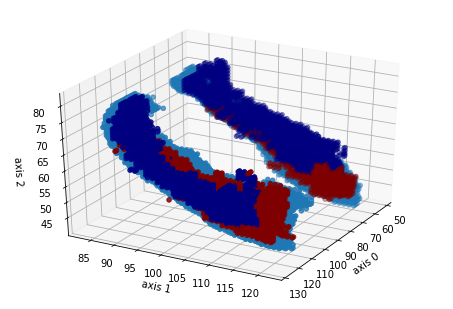

In [21]:
plt.close()
label_locations = np.where(hipp_labs.get_data() > 0)
label_locations1 = np.where(hipp.get_data() == 1)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations1[0], label_locations1[1], label_locations1[2], cmap='gray')
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = hipp_labs.get_data()[label_locations],
          cmap='jet')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()


In [25]:
temp_trace = plotly.graph_objs.Scatter3d(x = label_locations[0],
                                        y = label_locations[1],
                                        z = label_locations[2],
                                        name = 'hipp',
                                        mode = 'markers',
                                        marker = {'size': 5, 
                                                  'color': hipp_labs.get_data()[label_locations], 
                                                  'colorscale':'RdBu'}
                                        )


layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=[temp_trace], layout=layout)
plotly.offline.plot(fig, filename='tau_hipp_labels.html')


'file:///home/users/jvogel/git/hack_projects/tau_hipp_labels.html'

### Label samples

In [41]:
convert_coords(coord,'xyz')

(68.0, 84.0, 77.0)

In [53]:
hlab_dat = hipp_labs.get_data()
for i,row in df.iterrows():
    coord = [int(round(x)) for x in row[['mni_nlin_x','mni_nlin_y','mni_nlin_z']]]
    df.loc[i,'tau_cluster'] = hlab_dat[convert_coords(coord,'xyz')]

In [56]:
for lab in df.tau_cluster.unique():
    print(lab,len(df[df.tau_cluster==lab]))

0.0 54
1.0 84
3.0 32


In [60]:
hxp.head()

,10021_20,10021_21,10021_22,10021_23,10021_24,10021_525,10021_526,10021_527,10021_528,10021_529,...,9861_789,9861_791,9861_793,9861_797,9861_798,9861_799,9861_804,9861_805,9861_806,9861_807
0,-0.075680,0.687474,0.435731,-0.528432,0.151001,0.480406,0.660119,0.635282,-0.950707,-1.794701,...,-0.854386,-1.298184,-0.314338,-1.405429,-0.986159,-0.539705,0.310073,-0.185890,-0.760153,-1.156494
1,-0.105828,-0.080013,0.938624,0.340545,0.196417,-0.281919,-0.281919,-0.281919,-0.146346,-0.122736,...,-0.279874,-0.322989,-0.076614,-0.307653,-0.166291,-0.142514,-0.330683,-0.311726,0.071945,-0.190493
2,-0.124526,-0.101640,0.038588,0.044294,-0.304078,-0.337035,-0.274058,-0.337035,-0.128501,-0.064542,...,-0.088185,-0.329613,0.025157,-0.225742,-0.055409,-0.008256,-0.348750,-0.348750,-0.149676,0.042965
3,0.500797,0.369799,0.648277,-0.136394,-0.397970,-0.074482,-0.354070,0.290655,0.214679,0.156800,...,0.615837,1.837306,-0.399442,1.045389,1.043883,0.028797,0.890627,0.785455,-0.474766,0.043116
4,0.360384,-0.108787,0.579915,0.369534,0.009912,-0.048502,-0.070200,0.088653,0.062610,0.046749,...,1.111220,1.301074,0.367464,0.794877,0.685466,1.286411,0.407277,0.424040,0.685054,1.715385


In [59]:
h1_cols = ['%s_%s'%(df.loc[x,'donor'], df.loc[x,'sample']) for x in df[df.tau_cluster==1].index]
h3_cols = ['%s_%s'%(df.loc[x,'donor'], df.loc[x,'sample']) for x in df[df.tau_cluster==3].index]

In [61]:
h1xp = hxp[h1_cols]
h3xp = hxp[h3_cols]

In [62]:
h1xp.shape

(58692, 84)

In [63]:
h3xp.shape

(58692, 32)

### Run T-test for each probe

In [64]:
results = pandas.DataFrame(index = h1xp.index, columns = ['t','p'])
for i in h1xp.index:
    results.loc[i, ['t','p']] = stats.ttest_ind(h1xp.loc[i], h3xp.loc[i])
    if i%5000 == 0:
        print('finished',i)

finished 0
finished 5000
finished 10000
finished 15000
finished 20000
finished 25000
finished 30000
finished 35000
finished 40000
finished 45000
finished 50000
finished 55000


In [65]:
results.loc[:,'Q_hs'] = multipletests(results.p)[1]
results.loc[:,'Q_bh'] = multipletests(results.p, method = 'fdr_bh')[1]
results.loc[:,'Q_bonf'] = multipletests(results.p, method = 'bonferroni')[1]

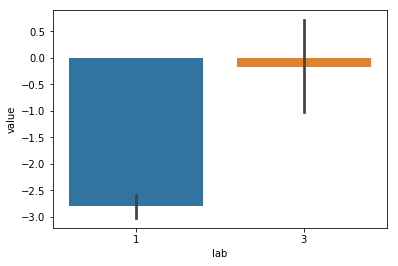

In [330]:
forplot = pandas.DataFrame(pandas.concat([h1xp.loc[24026], h3xp.loc[24026]]))
forplot.columns = ['value']
forplot.loc[:, 'lab'] = [1]*len(h1xp.columns) + [3]*len(h3xp.columns)
forplot.head()
plt.close()
sns.barplot('lab','value',data=forplot)
plt.show()

In [67]:
results.sort_values('Q_bonf').head()

,t,p,Q_hs,Q_bh,Q_bonf
24026,-7.97004,1.33504e-12,7.83564e-08,7.83564e-08,7.83564e-08
15480,7.25473,5.23006e-11,3.06957e-06,1.53481e-06,3.06963e-06
36978,-7.09157,1.18895e-10,6.9779e-06,2.32606e-06,6.97817e-06
20320,-6.9799,2.07797e-10,1.21953e-05,3.04901e-06,1.2196e-05
25014,6.90708,2.98535e-10,1.75203e-05,3.34537e-06,1.75216e-05


In [69]:
results[results.Q_bonf<0.05].sort_values('t')

,t,p,Q_hs,Q_bh,Q_bonf
24026,-7.97004,1.33504e-12,7.83564e-08,7.83564e-08,7.83564e-08
36978,-7.09157,1.18895e-10,6.9779e-06,2.32606e-06,6.97817e-06
20320,-6.9799,2.07797e-10,1.21953e-05,3.04901e-06,1.2196e-05
20319,-6.87969,3.41992e-10,2.00703e-05,3.34537e-06,2.00722e-05
37101,-6.72599,7.30458e-10,4.28668e-05,5.29517e-06,4.28721e-05
15970,-6.67785,9.25168e-10,5.42902e-05,5.43e-06,5.43e-05
52574,-6.48218,2.40037e-09,0.000140846,1.17402e-05,0.000140883
9307,-6.42206,3.20972e-09,0.000188329,1.30835e-05,0.000188385
28305,-6.40926,3.41417e-09,0.00020032,1.30835e-05,0.000200385
39126,-6.36312,4.26293e-09,0.000250105,1.30835e-05,0.0002502


In [70]:
probes = pandas.read_csv('/data1/users/jvogel/Allen_Human_Brain_Atlas/normalized_microarray_donor10021/Probes.csv')

In [71]:
probes.loc[results[results.Q_bonf<0.05].sort_values('t').index]['gene_name']

24026                                    docking protein 7
36978                   glutamate receptor, metabotropic 8
20320                    muscular LMNA-interacting protein
20319                    muscular LMNA-interacting protein
37101                     FERM and PDZ domain containing 2
15970                  chromosome 21 open reading frame 62
52574                  chromosome 1 open reading frame 145
9307     thymocyte selection-associated high mobility g...
28305             prostaglandin E receptor 3 (subtype EP3)
39126               src kinase associated phosphoprotein 1
42650    von Willebrand factor C domain containing prot...
29460    cytochrome P450, family 26, subfamily A, polyp...
19725                   chromosome 9 open reading frame 24
53715               AGILENT probe A_32_P11425 (non-RefSeq)
14349                                          contactin 5
27185                   cholinergic receptor, muscarinic 2
4992        protein tyrosine phosphatase, receptor type,

In [95]:
results.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/TAU_NLIN_results.csv')

In [74]:
top_res = results[results.Q_bonf<0.05].sort_values('t')

In [75]:
top_res.loc[:,'gene_name'] = probes.loc[top_res.index]['gene_name']
top_res.loc[:,'gene_symbol'] = probes.loc[top_res.index]['gene_symbol']

In [94]:
top_res[top_res.t > 0]['gene_symbol'].tolist()

['NEUROD2',
 'GRIA1',
 'CDC40',
 'SLC17A7',
 'RAB3D',
 'CAB39L',
 'SDK1',
 'ADCY9',
 'ERC1',
 'ERC1',
 'CACNG8',
 'BSN',
 'CELF3',
 'PARD6G-AS1',
 'LINC00338',
 'NPTXR',
 'SLC24A3',
 'DCC',
 'CDC40',
 'PRKCE',
 'A_24_P494600',
 'ZNF608',
 'ALPK1',
 'ERC1',
 'PPFIBP1',
 'CARM1',
 'BCAS4',
 'GRIA1',
 'ABI1',
 'MAP4K3',
 'ZNF189',
 'CAMK2B',
 'A_32_P136304',
 'A_24_P365349',
 'UNC13A',
 'TANC1',
 'AC022596.6',
 'SUSD4',
 'SOCS7',
 'RAP2B',
 'HERC4',
 'AC058791.2',
 'A_24_P126741',
 'SORT1',
 'A_24_P703614',
 'ST3GAL2',
 'FLJ23867',
 'ACTR3',
 'LPL',
 'HERC4',
 'CHGB',
 'TTC39C',
 'ZBTB20',
 'A_24_P332263',
 'SLC9A2',
 'LRP12',
 'CPNE4',
 'A_24_P943723',
 'ZCCHC18',
 'PTPN1',
 'ACTR3',
 'HPCA',
 'WBSCR17',
 'ARHGEF3',
 'SLC24A3',
 'PGBD5',
 'C21orf88',
 'CELSR2',
 'ABL2',
 'PRICKLE2',
 'KRTAP4-8',
 'AJAP1',
 'ZBTB20',
 'GRIA1',
 'NR3C2',
 'GEFT',
 'WASF1',
 'SMPD3',
 'RP11-291L15.2',
 'CAMK2A',
 'CAMK2B',
 'SEC14L1',
 'NT5DC3',
 'PPM1E',
 'KCNJ6',
 'A_32_P215669',
 'LOC284033',
 'GLRX',
 '

In [88]:
df[df.tau_cluster==1]['structure_acronym'].value_counts() / len(df[df.tau_cluster==1])

CA4    0.250000
CA3    0.214286
DG     0.214286
CA2    0.190476
CA1    0.130952
Name: structure_acronym, dtype: float64

In [89]:
df[df.tau_cluster==3]['structure_acronym'].value_counts() / len(df[df.tau_cluster==3])

S      0.40625
DG     0.18750
CA1    0.15625
CA3    0.12500
CA4    0.09375
CA2    0.03125
Name: structure_acronym, dtype: float64

In [90]:
top_res[top_res.t < 0]['gene_symbol'].tolist()

['DOK7',
 'GRM8',
 'C6orf142',
 'C6orf142',
 'FRMPD2',
 'C21orf62',
 'C1orf145',
 'TOX',
 'PTGER3',
 'SKAP1',
 'VWC2L',
 'CYP26A1',
 'C9orf24',
 'A_32_P11425',
 'CNTN5',
 'CHRM2',
 'PTPRR',
 'UTS2',
 'PTGER3',
 'ATP6V1C2',
 'EPB41L4B',
 'DPY19L1',
 'DPY19L1',
 'ETV1',
 'RPRM',
 'CRYM',
 'MACROD2',
 'CRYGD',
 'WFDC2',
 'C21orf62',
 'APOC1',
 'A_24_P38316',
 'TOX',
 'CNTN4',
 'STMN1',
 'CPLX3',
 'CHRM2',
 'GALNTL5',
 'CRYGD',
 'TMEM159',
 'FGF12',
 'YPEL2',
 'ARID5B',
 'NTSR1',
 'NDST4',
 'GALNTL5',
 'DPY19L1',
 'SORCS1',
 'CHODL',
 'SULF1',
 'APOC1',
 'A_32_P168375',
 'GUCA1C',
 'C9orf24',
 'CNTN5',
 'KIAA0748',
 'NTNG1',
 'A_32_P429876',
 'TSHZ3',
 'ARPP19',
 'CABLES1',
 'CRYBB1',
 'FOXP2',
 'SORCS1',
 'LRP2',
 'DLG1',
 'DPY19L1',
 'ADAMTSL3',
 'APOC1',
 'RP11-347C12.3',
 'C12orf42',
 'EPHX4',
 'ASXL3',
 'FUT9',
 'CHODL',
 'PCDH11Y',
 'A_32_P74206',
 'VWC2L',
 'TH',
 'CHRM2',
 'KIAA0748',
 'TOX',
 'CNTN4',
 'TOX3',
 'IQGAP3',
 'PCDH11Y',
 'ADAM2',
 'FGF12',
 'APOC4',
 'CD55',
 'NTNG1',

In [92]:
results.loc[:,'gene_name'] = probes.loc[results.index]['gene_name']
results.loc[:,'gene_symbol'] = probes.loc[results.index]['gene_symbol']

In [96]:
top_res.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/TAU_NLIN_top_results.csv')

In [97]:
rank = pandas.DataFrame(index = results.gene_symbol.unique(), columns = ['t'])
for i,gene in enumerate(results.gene_symbol.unique()):
    db = results[results.gene_symbol==gene]['t']
    if type(db) == float:
        rank.loc[gene,'t'] = db
    else:
        rank.loc[gene,'t'] = db.mean()
    if i%1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [100]:
rank.sort_values('t',ascending=False)

,t
SMPD3,6.62692
GLRX,6.36361
A_24_P924301,6.33346
LOC284033,6.10059
A_32_P215669,6.09406
HPCA,6.01504
PTPN1,5.91227
AC022596.6,5.89567
AC007510.1,5.74274
A_24_P332263,5.61551


In [113]:
new_rank = pandas.DataFrame(index = range(len(rank)))

In [115]:
new_rank.loc[:,'Symbol'] = rank.index
new_rank.loc[:,'t'] = rank.t.values
new_rank.head()

,Symbol,t
0,C8G,0.372559
1,C9,0.920898
2,MRPL49,2.027344
3,ZNHIT2,0.604980
4,MPPED2,2.455078


In [117]:
new_rank.sort_values('t',ascending=False
                ).to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/GSEA_rank_tau_1v3_NLIN.rnk',
                        sep = '\t', index=False)

### Look at covariance with tau-PET signal

* Average AD (or amyloid+ image)
* subtraction mask
* ROIs

First use provided DKT ROIs and look at gene expression vs. tau for each

In [131]:
wbdf = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_gcx_wholebrain_info.csv',
                      index_col = 0)
wbdf.shape

(3702, 21)

In [364]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
ncols = ['%s_%s'%(wbdf.loc[x,'donor'],bigdf.columns[x]) for x in range(wbdf.shape[0])]
bigdf.columns = ncols

In [136]:
bigdf.shape

(58692, 3702)

In [331]:
h1_genes = bigdf.loc[top_res[top_res.t > 0].index]
h3_genes = bigdf.loc[top_res[top_res.t < 0].index]

NameError: name 'bigdf' is not defined

In [332]:
# jnk = pandas.DataFrame(h1_genes,copy=True)
# h1_genes = pandas.DataFrame(h3_genes,copy=True)
# h3_genes = pandas.DataFrame(jnk,copy=True)


In [333]:
h3_genes.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/TAU_NLIN_h3_wholebrain_gxp')
h1_genes.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/TAU_NLIN_h1_wholebrain_gxp')

In [146]:
# get cortical mask
dkt = ni.load('/home/users/jvogel/Science/templates/atlases/dkt_atlas_1mm.nii').get_data().astype(int)
labs = pandas.read_csv('/home/users/jvogel/git/pycourse/stuff/dst_labels.csv', header=None)
labs.columns = ['label','ROI']
labs.head()

,label,ROI
0,1,Caudal anterior cingulate
1,2,Caudal middle frontal
2,3,Cuneus
3,4,entorinal
4,5,fusiform


In [154]:
labs[labs.label==lab]['ROI'].values[0]

' Putamen'

In [158]:
subcort = labs.loc[31:38,'label'].tolist() + labs.loc[70:,'label'].tolist()
for i,row in wbdf.iterrows():
    coord = [int(round(x)) for x in row[['mni_nlin_x','mni_nlin_y','mni_nlin_z']]]
    lab = dkt[convert_coords(coord,'xyz')]
    wbdf.loc[i,'dkt_label'] = lab
    if lab in labs.label.tolist():
        wbdf.loc[i,'dkt_region'] = labs[labs.label==lab]['ROI'].values[0]

In [161]:
#list(zip(wbdf.structure_name,wbdf.dkt_region))

In [162]:
wdir = '/home/users/jvogel/git/data_driven_pathology/stuff'

In [163]:
# load data
adnidf = pandas.read_csv(os.path.join(wdir,'UCBERKELEYAV1451_11_14_17.csv'))
adnidf = adnidf.sort_values(['RID','EXAMDATE'])

In [164]:
# identify target columns
# HINT: you may want to use the data dictionary to convert the columns to a more
# comprehensible format -- otherwise the method employed in this notebook won't really work
ctx_cols = [x for x in adnidf.columns if 'CTX_' in x and 'SIZE' not in x]
hits = ['AMYGDALA', 'CAUDATE', 'HIPPOCAMPUS', 'PALLIDUM', 'PUTAMEN', 'THALAMUS', 'ACCUMBENS']
subcols = [x for x in adnidf.columns if any([y in x for y in hits]) and 'SIZE' not in x]
goodcols = ['RID'] + ctx_cols + subcols


In [165]:
# make new spreadsheet with just the target columns
nsdf = pandas.DataFrame(adnidf[goodcols])
nsdf.drop(nsdf.columns[0],axis=1,inplace=True)
nsdf.columns = nsdf.columns[:-7].tolist() + ['RIGHT_ACCUMBENS_AREA'] + nsdf.columns[-6:].tolist()

In [166]:
ldf = labs
# add hemispheric info
lhctx = ['LH %s'%x.upper().replace(' ','') for x in ldf.ROI[:31]]
lsc = ['LEFT %s'%x.upper().replace(' ','') for x in ldf.ROI[31:39]]
rhctx = ['RH %s'%x.upper().replace(' ','') for x in ldf.ROI[39:70]]
rsc = ['RIGHT %s'%x.upper().replace(' ','') for x in ldf.ROI[70:78]]
ldf.loc[ldf.index[:78],'newlabs'] = lhctx + lsc + rhctx + rsc

In [167]:
import difflib
# use difflib to find the best matches for each column
for i,row in ldf.iterrows():
    if i < 78:
        roi = row['newlabs']
        match = difflib.get_close_matches(roi,nsdf.columns)
        if len(match) == 0:
            ldf.loc[i,'matching_lab'] = np.nan
        else:
            ldf.loc[i,'matching_lab'] = match[0]

In [168]:
# deal with the accumbens...
ldf.loc[ldf.index[31],'matching_lab'] = 'LEFT_ACCUMBENS_AREA'
ldf.loc[ldf.index[33],'matching_lab'] = np.nan
ldf.loc[ldf.index[70],'matching_lab'] = 'RIGHT_ACCUMBENS_AREA'
ldf.loc[ldf.index[72],'matching_lab'] = np.nan

In [169]:
# get rid of the ROIs that seem to be missing from the volumetric atlas..
to_drop = [x for x in nsdf.columns if 'POLE' in x or 'BANKS' in x or 'UNKNOWN' in x]
nsdf.drop(to_drop,axis=1,inplace=True)
nsdf.shape

(246, 76)

In [170]:
# reindex the spreadsheet
nsdf = nsdf.reindex(columns=ldf.matching_lab.dropna().values)

In [171]:
# now deal with that weird unidentifiable ROI...
final_cols = nsdf.columns[:33].tolist() + ['MISSING1'] + nsdf.columns[33:71].tolist() + ['MISSING2'] + nsdf.columns[71:].tolist()

In [172]:
# last step!
nsdf = nsdf.reindex(columns=final_cols)

In [175]:
# how did we do?
nsdf.shape

(246, 78)

In [177]:
ldf.head()

,label,ROI,newlabs,matching_lab
0,1,Caudal anterior cingulate,LH CAUDALANTERIORCINGULATE,CTX_LH_CAUDALANTERIORCINGULATE
1,2,Caudal middle frontal,LH CAUDALMIDDLEFRONTAL,CTX_LH_CAUDALMIDDLEFRONTAL
2,3,Cuneus,LH CUNEUS,CTX_LH_CUNEUS
3,4,entorinal,LH ENTORINAL,CTX_LH_ENTORHINAL
4,5,fusiform,LH FUSIFORM,CTX_LH_FUSIFORM


In [334]:
h3_DKT = pandas.DataFrame(index = h3_genes.index, columns = ldf.label[:78])
for roi in h3_DKT.columns:
    roi_cols = wbdf[wbdf.dkt_label==roi].index
    roi_xp = h3_genes[h3_genes.columns[roi_cols]]
    h3_DKT.loc[:,roi] = roi_xp.mean(axis=1).values

In [335]:
h1_DKT = pandas.DataFrame(index = h1_genes.index, columns = ldf.label[:78])
for roi in h1_DKT.columns:
    roi_cols = wbdf[wbdf.dkt_label==roi].index
    roi_xp = h1_genes[h1_genes.columns[roi_cols]]
    h1_DKT.loc[:,roi] = roi_xp.mean(axis=1).values

In [220]:
tdf = pandas.read_csv('/home/users/jvogel/Science/ADNI_tau/big_tau.csv', index_col = 0)

In [228]:
nsdf_ref = pandas.DataFrame(index = nsdf.index)
nsdf_ref.loc[:,'RID'] = adnidf.RID
nsdf_ref.loc[:,'EXAMDATE'] = adnidf.EXAMDATE

In [ ]:
tdf.loc[:,'RID'] = [int(x.split('_')[-1]) for x in tdf.ID]

In [273]:
cols = tdf.columns[:3].tolist() + tdf.columns[28:30].tolist()
for i,row in nsdf_ref.iterrows():
    if row['RID'] in tdf.RID.tolist():
        trow = tdf[tdf.RID == row['RID']]
        if len(trow) == 1:
            for col in cols:
                nsdf_ref.loc[i,col] = trow[col].values[0]
        else:
            for j in trow.index:
                if trow.loc[j,'scandate'] == row['EXAMDATE']:
                    trow = trow.loc[j]
                    break
            for col in cols:
                nsdf_ref.loc[i,col] = trow[col]

In [336]:
ad_DKT = nsdf.loc[nsdf_ref[(nsdf_ref.DX_fill == 'Dementia') & (nsdf_ref.av45_status == 1)].index]

In [290]:
[x for x in range(len(ad_DKT.columns)) if 'MISSING' in ad_DKT.columns[x]]

[33, 72]

In [337]:
ad_DKT.drop(ad_DKT.columns[[33,72]],axis=1, inplace=True)
h3_DKT.drop(h3_DKT.columns[[33,72]],axis=1, inplace=True)
h1_DKT.drop(h1_DKT.columns[[33,72]],axis=1, inplace=True)

In [338]:
h3_TAU_results = pandas.DataFrame(index = h3_DKT.index, columns = ['t','p','gene_name'])
for gene in h3_DKT.index:
    g_name = probes.loc[gene]['gene_symbol']
    r, p = stats.pearsonr(h3_DKT.loc[gene].values,
                         ad_DKT.mean().values)
    print(g_name,r,p)
    h3_TAU_results.loc[gene] = [r,p,g_name]

DOK7 0.0195678773844 0.866758226782
GRM8 -0.321628505092 0.00460964786117
C6orf142 -0.322817699889 0.00445244861206
C6orf142 -0.352835199879 0.00177101246638
FRMPD2 -0.360930121506 0.00135969904973
C21orf62 -0.323023074788 0.00442578735463
C1orf145 0.288471264431 0.0115000315756
TOX -0.401064801375 0.000330126069682
PTGER3 0.257521817578 0.0247142753401
SKAP1 -0.077929425235 0.503411123159
VWC2L -0.308608806579 0.00668085760775
CYP26A1 -0.49942065604 4.37791662415e-06
C9orf24 -0.168156364118 0.146496211262
A_32_P11425 -0.406980603367 0.00026382353615
CNTN5 -0.215164913645 0.06195687759
CHRM2 -0.413126708002 0.000208079331476
PTPRR -0.0919047495801 0.429760491603
UTS2 0.270278588379 0.0182103438291
PTGER3 0.395602235987 0.000404572876822
ATP6V1C2 -0.373698600795 0.000883611426756
EPB41L4B -0.178343063934 0.12322505903
DPY19L1 -0.458394684468 3.12537867473e-05
DPY19L1 -0.490667161199 6.80346414917e-06
ETV1 -0.323005175588 0.00442810533391
RPRM -0.250652773485 0.0289683445932
CRYM -0.2588

In [339]:
h3_TAU_results.loc[:,'Q_hs'] = multipletests(h3_TAU_results.p)[1]
h3_TAU_results.loc[:,'Q_bh'] = multipletests(h3_TAU_results.p, method = 'fdr_bh')[1]
h3_TAU_results.loc[:,'Q_bonf'] = multipletests(h3_TAU_results.p, method = 'bonferroni')[1]

In [340]:
h3_TAU_results.sort_values('Q_bonf')

,t,p,gene_name,Q_hs,Q_bh,Q_bonf
44749,0.559349,1.50253e-07,APOC1,1.6077e-05,7.32349e-06,1.60771e-05
44462,0.555522,1.90123e-07,APOC1,2.01528e-05,7.32349e-06,2.03431e-05
44750,0.551246,2.46459e-07,APOC1,2.58779e-05,7.32349e-06,2.63711e-05
39970,-0.545777,3.41696e-07,IPCEF1,3.55358e-05,7.32349e-06,3.65615e-05
902,-0.542165,4.22664e-07,CRYBB1,4.35335e-05,7.32349e-06,4.52251e-05
38314,-0.539958,4.80718e-07,KIAA0748,4.9032e-05,7.32349e-06,5.14368e-05
8013,-0.538033,5.37436e-07,KMO,5.42796e-05,7.32349e-06,5.75057e-05
42966,-0.53771,5.47551e-07,KIAA0748,5.47536e-05,7.32349e-06,5.85879e-05
37025,-0.522521,1.28766e-06,KIAA1107,0.000127471,1.53089e-05,0.00013778
29460,-0.499421,4.37792e-06,CYP26A1,0.000428945,4.68437e-05,0.000468437


APOC1 r = 0.559348537454, FWE Q = 1.60771218037e-05


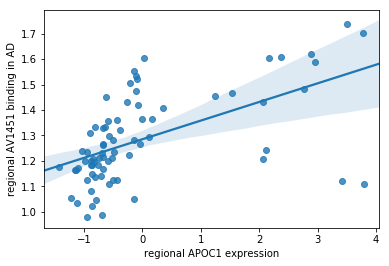



APOC1 r = 0.55552220386, FWE Q = 2.0343143333e-05


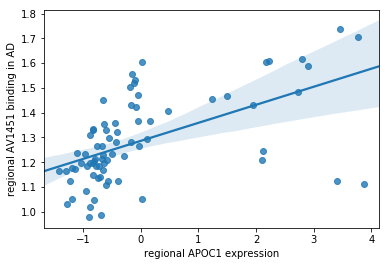



APOC1 r = 0.551246464529, FWE Q = 2.63711407879e-05


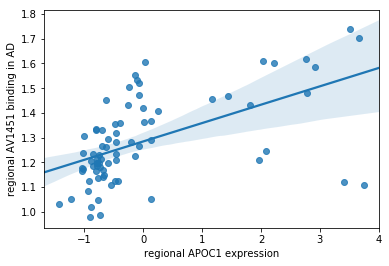



IPCEF1 r = -0.545777480621, FWE Q = 3.65615084212e-05


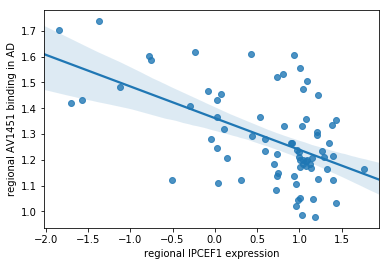



CRYBB1 r = -0.542164985134, FWE Q = 4.52250963841e-05


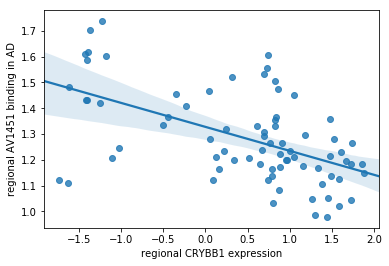



KIAA0748 r = -0.539957967374, FWE Q = 5.14367976174e-05


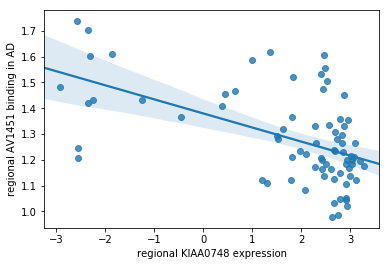



KMO r = -0.538032611166, FWE Q = 5.75056622346e-05


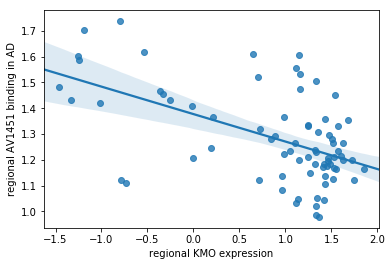



KIAA0748 r = -0.537709558458, FWE Q = 5.85879477701e-05


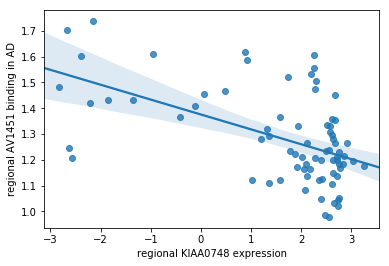



KIAA1107 r = -0.522521164779, FWE Q = 0.000137780145991


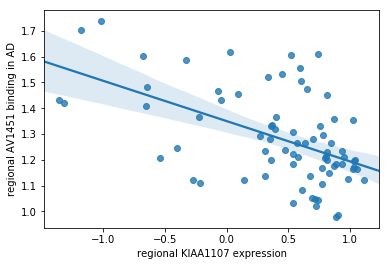



CYP26A1 r = -0.49942065604, FWE Q = 0.000468437078784


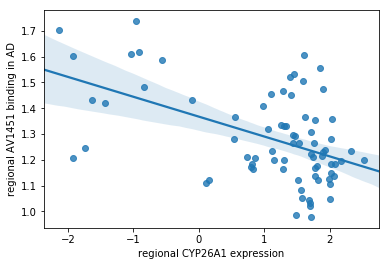



DPY19L1 r = -0.490667161199, FWE Q = 0.000727970663961


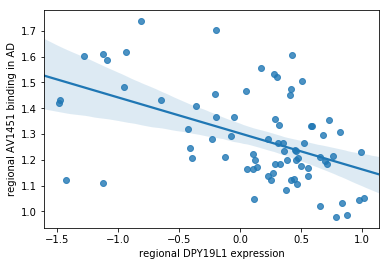



APOC4 r = 0.487887033327, FWE Q = 0.000835272240851


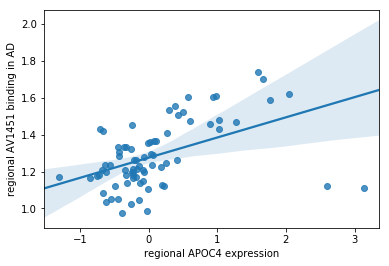



DPY19L1 r = -0.474503318519, FWE Q = 0.00159265065881


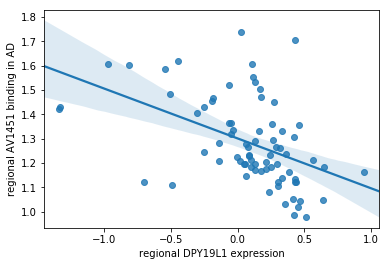



IQGAP3 r = -0.462518225833, FWE Q = 0.00277557958019


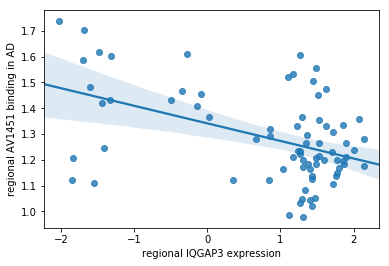



DPY19L1 r = -0.458394684468, FWE Q = 0.00334415518196


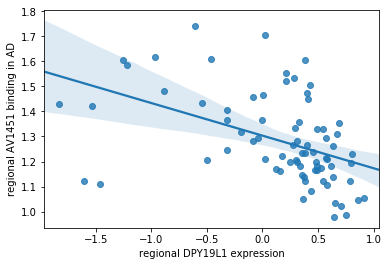



EPHX4 r = -0.457358185192, FWE Q = 0.00350321361995


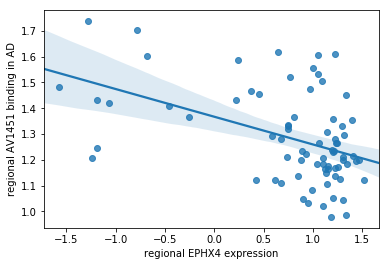



FOXP2 r = -0.430005426288, FWE Q = 0.0113272061352


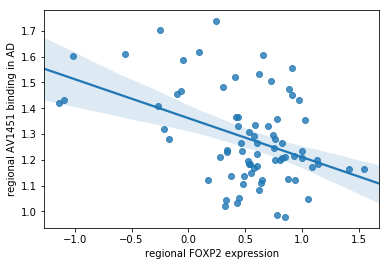



CHODL r = 0.425952134858, FWE Q = 0.01336652694


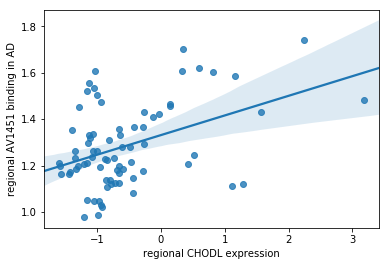



NDST4 r = 0.424542387071, FWE Q = 0.0141518080768


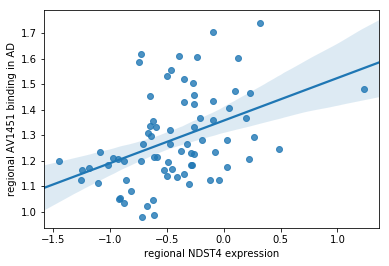



SORCS1 r = -0.418860958185, FWE Q = 0.0177678031481


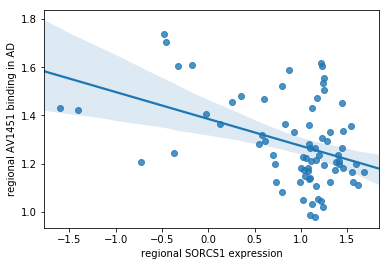



TOX r = -0.416900149399, FWE Q = 0.0192014913756


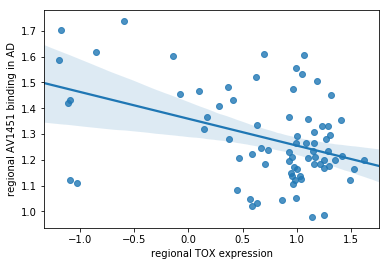



SORCS1 r = -0.413471651457, FWE Q = 0.0219668755117


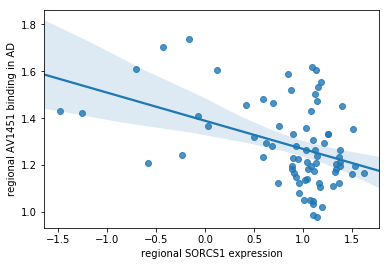



CHRM2 r = -0.413126708002, FWE Q = 0.022264488468


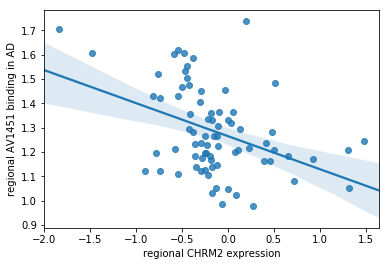



NTNG1 r = -0.413043625742, FWE Q = 0.022336722892


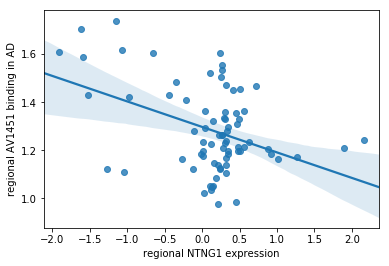



CABLES1 r = 0.411584440135, FWE Q = 0.0236410456329


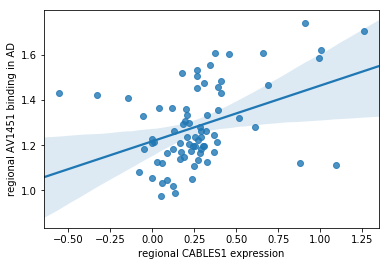



A_32_P11425 r = -0.406980603367, FWE Q = 0.028229118368


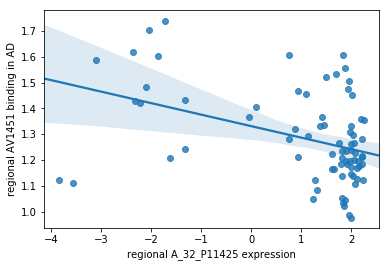



A_32_P429876 r = -0.40406821757, FWE Q = 0.0315396480508


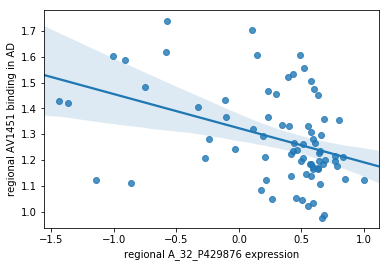



A_32_P168375 r = -0.403902670208, FWE Q = 0.0317381187109


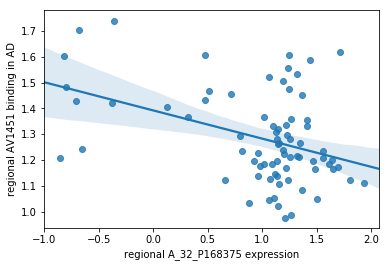



TOX r = -0.401064801375, FWE Q = 0.035323489456


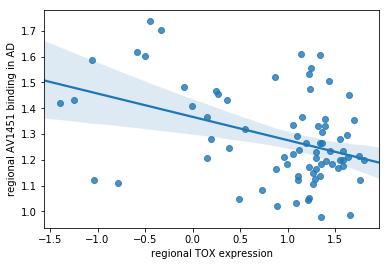



ARID5B r = -0.397090131339, FWE Q = 0.0409708141249


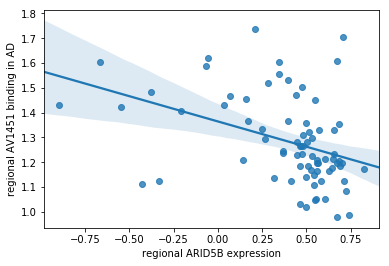



PTGER3 r = 0.395602235987, FWE Q = 0.04328929782


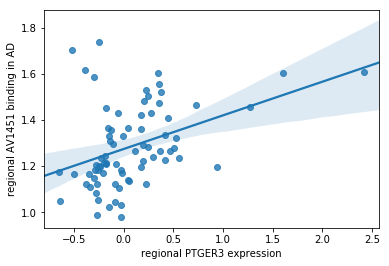



CHRM2 r = -0.391875062034, FWE Q = 0.0496336893606


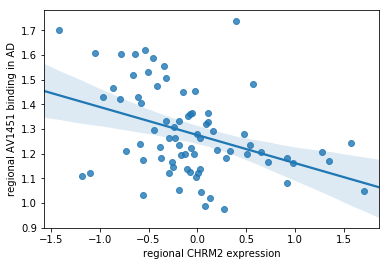

In [341]:
for i,row in h3_TAU_results.sort_values('Q_bonf').iterrows():
    if row['Q_bonf'] < 0.05:
        print(row['gene_name'], 'r = %s, FWE Q = %s'%(row['t'],row['Q_bonf']))
        plt.close()
        sns.regplot(h3_DKT.loc[i].values,
                   ad_DKT.mean().values)
        plt.xlabel('regional %s expression'%(row['gene_name']))
        plt.ylabel('regional AV1451 binding in AD')
        plt.show()
        print('\n')

8 positive associated, 24 negatively associated

APOC1 r = 0.559348537454, FWE Q = 1.60771218037e-05


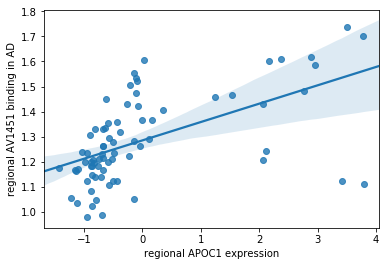



APOC1 r = 0.55552220386, FWE Q = 2.0343143333e-05


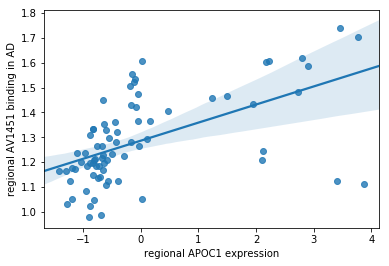



APOC1 r = 0.551246464529, FWE Q = 2.63711407879e-05


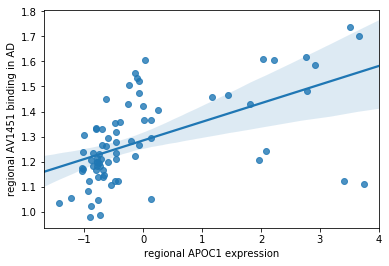



IPCEF1 r = -0.545777480621, FWE Q = 3.65615084212e-05


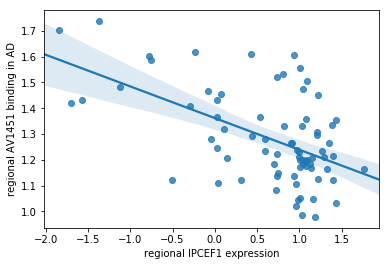



CRYBB1 r = -0.542164985134, FWE Q = 4.52250963841e-05


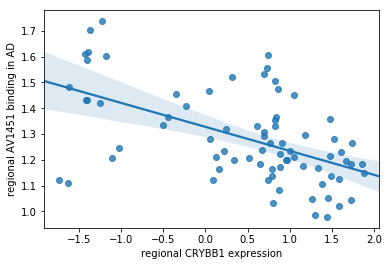



KIAA0748 r = -0.539957967374, FWE Q = 5.14367976174e-05


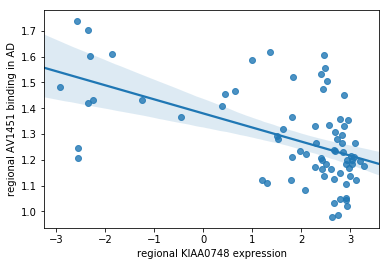



KMO r = -0.538032611166, FWE Q = 5.75056622346e-05


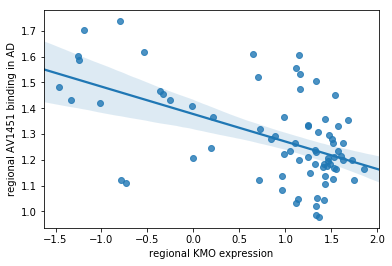



KIAA0748 r = -0.537709558458, FWE Q = 5.85879477701e-05


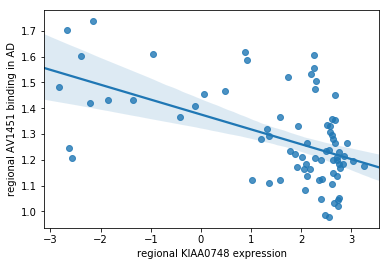



KIAA1107 r = -0.522521164779, FWE Q = 0.000137780145991


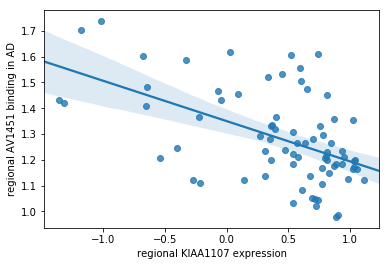



CYP26A1 r = -0.49942065604, FWE Q = 0.000468437078784


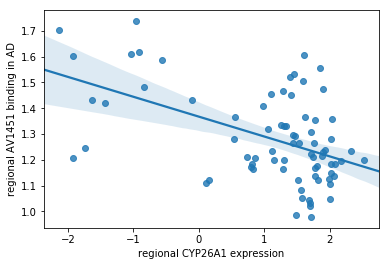



DPY19L1 r = -0.490667161199, FWE Q = 0.000727970663961


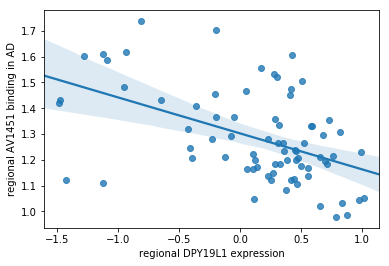



APOC4 r = 0.487887033327, FWE Q = 0.000835272240851


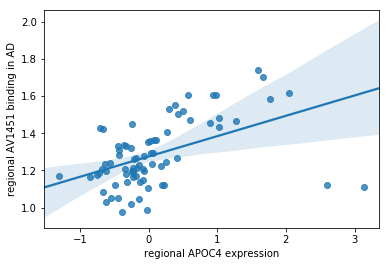



DPY19L1 r = -0.474503318519, FWE Q = 0.00159265065881


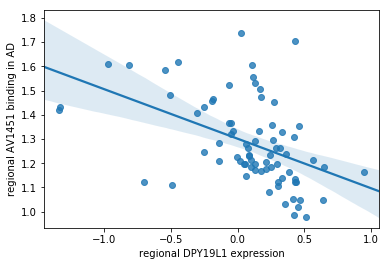



IQGAP3 r = -0.462518225833, FWE Q = 0.00277557958019


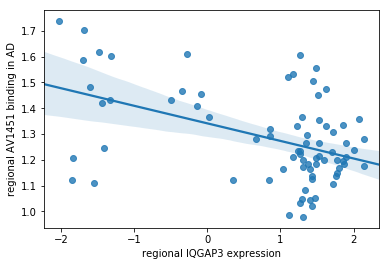



DPY19L1 r = -0.458394684468, FWE Q = 0.00334415518196


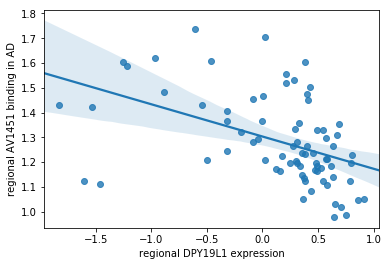



EPHX4 r = -0.457358185192, FWE Q = 0.00350321361995


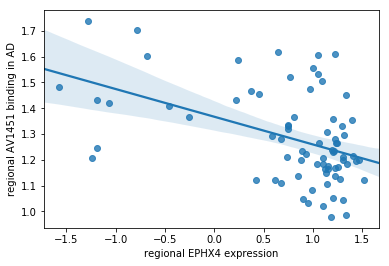



FOXP2 r = -0.430005426288, FWE Q = 0.0113272061352


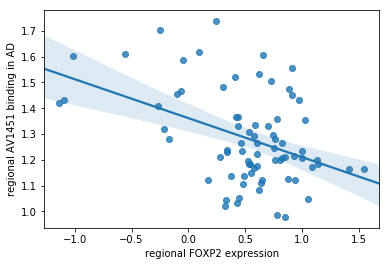



CHODL r = 0.425952134858, FWE Q = 0.01336652694


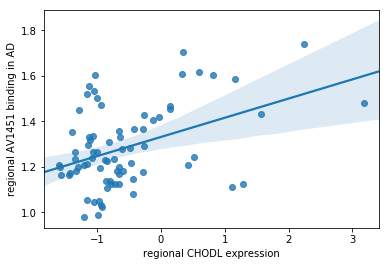



NDST4 r = 0.424542387071, FWE Q = 0.0141518080768


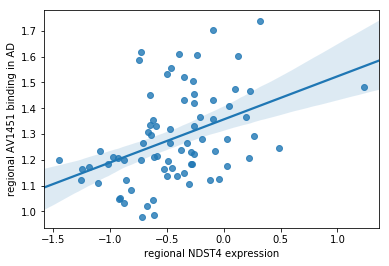



SORCS1 r = -0.418860958185, FWE Q = 0.0177678031481


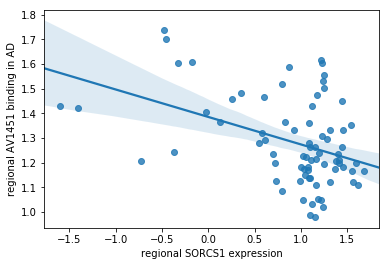



TOX r = -0.416900149399, FWE Q = 0.0192014913756


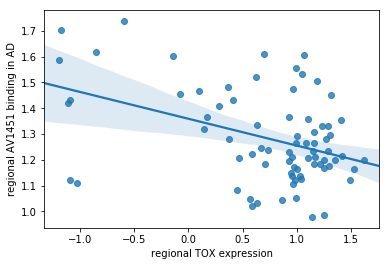



SORCS1 r = -0.413471651457, FWE Q = 0.0219668755117


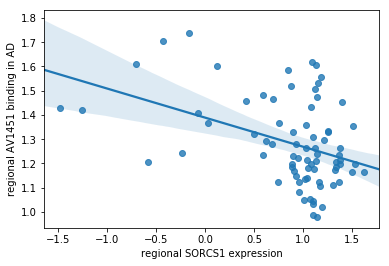



CHRM2 r = -0.413126708002, FWE Q = 0.022264488468


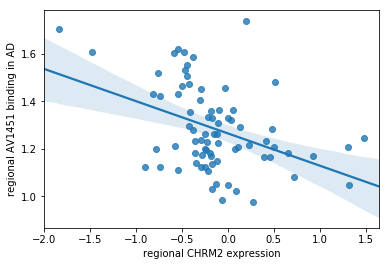



NTNG1 r = -0.413043625742, FWE Q = 0.022336722892


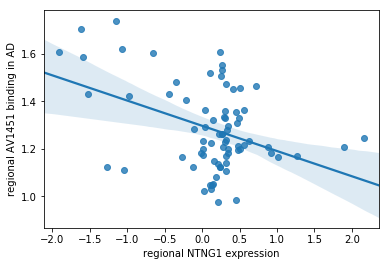



CABLES1 r = 0.411584440135, FWE Q = 0.0236410456329


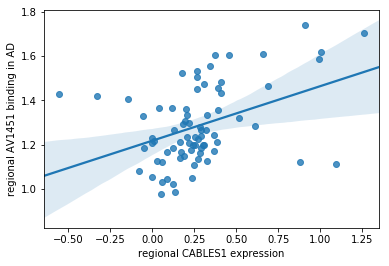



A_32_P11425 r = -0.406980603367, FWE Q = 0.028229118368


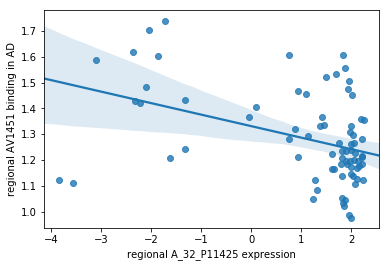



A_32_P429876 r = -0.40406821757, FWE Q = 0.0315396480508


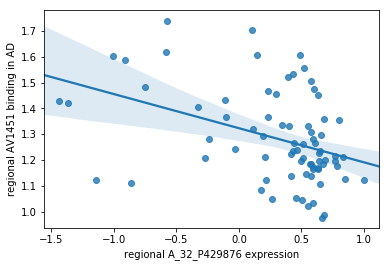



A_32_P168375 r = -0.403902670208, FWE Q = 0.0317381187109


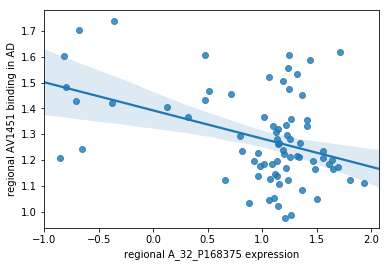



TOX r = -0.401064801375, FWE Q = 0.035323489456


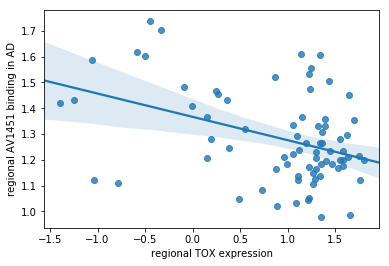



ARID5B r = -0.397090131339, FWE Q = 0.0409708141249


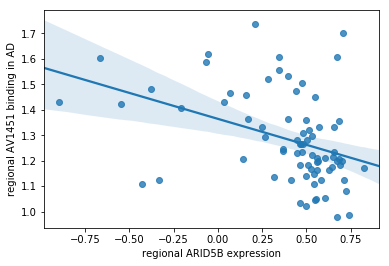



PTGER3 r = 0.395602235987, FWE Q = 0.04328929782


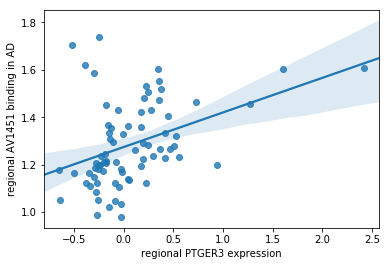



CHRM2 r = -0.391875062034, FWE Q = 0.0496336893606


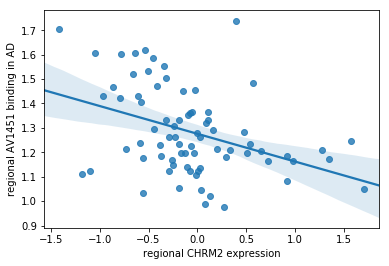

In [309]:
h1_TAU_results = pandas.DataFrame(index = h1_DKT.index, columns = ['t','p','gene_name'])
for gene in h1_DKT.index:
    g_name = probes.loc[gene]['gene_symbol']
    r, p = stats.pearsonr(h1_DKT.loc[gene].values,
                         ad_DKT.mean().values)
    h1_TAU_results.loc[gene] = [r,p,g_name]
h1_TAU_results.loc[:,'Q_hs'] = multipletests(h1_TAU_results.p)[1]
h1_TAU_results.loc[:,'Q_bh'] = multipletests(h1_TAU_results.p, method = 'fdr_bh')[1]
h1_TAU_results.loc[:,'Q_bonf'] = multipletests(h1_TAU_results.p, method = 'bonferroni')[1]
for i,row in h1_TAU_results.sort_values('Q_bonf').iterrows():
    if row['Q_bonf'] < 0.05:
        print(row['gene_name'], 'r = %s, FWE Q = %s'%(row['t'],row['Q_bonf']))
        plt.close()
        sns.regplot(h1_DKT.loc[i].values,
                   ad_DKT.mean().values)
        plt.xlabel('regional %s expression'%(row['gene_name']))
        plt.ylabel('regional AV1451 binding in AD')
        plt.show()
        print('\n')

16 positive correlation, 5 negative

### Now lets repeat but excluding subcortical ROIS

In [342]:
subcort = list(range(31,38)) + list(range(69,76))

In [343]:
ad_DKT.columns[subcort]

Index(['LEFT_ACCUMBENS_AREA', 'LEFT_AMYGDALA', 'LEFT_CAUDATE',
       'LEFT_HIPPOCAMPUS', 'LEFT_PALLIDUM', 'LEFT_PUTAMEN',
       'LEFT_THALAMUS_PROPER', 'RIGHT_ACCUMBENS_AREA', 'RIGHT_AMYGDALA',
       'RIGHT_CAUDATE', 'RIGHT_HIPPOCAMPUS', 'RIGHT_PALLIDUM', 'RIGHT_PUTAMEN',
       'RIGHT_THALAMUS_PROPER'],
      dtype='object')

In [344]:
Cad_DKT = ad_DKT.drop(ad_DKT.columns[subcort],axis=1)
Ch3_DKT = h3_DKT.drop(h3_DKT.columns[subcort],axis=1)
Ch1_DKT = h1_DKT.drop(h1_DKT.columns[subcort],axis=1)

In [352]:
print('AD',stats.normaltest(Cad_DKT.mean()))
for i in Ch3_DKT.index:
    print(i,stats.normaltest(Ch3_DKT.loc[i]))

AD NormaltestResult(statistic=2.5170791336775538, pvalue=0.28406858689157338)
24026 NormaltestResult(statistic=0.61636291023366019, pvalue=0.73478197596234329)
36978 NormaltestResult(statistic=12.517513036798309, pvalue=0.0019136238738566549)
20320 NormaltestResult(statistic=20.765532687938233, pvalue=3.096149123278415e-05)
20319 NormaltestResult(statistic=23.081761325780075, pvalue=9.7243193279874927e-06)
37101 NormaltestResult(statistic=11.245440974923163, pvalue=0.0036147937191996966)
15970 NormaltestResult(statistic=6.9469606038633938, pvalue=0.031008922233249511)
52574 NormaltestResult(statistic=0.90225164475344155, pvalue=0.63691069951824608)
9307 NormaltestResult(statistic=16.490666585035008, pvalue=0.00026248062386161064)
28305 NormaltestResult(statistic=2.488387842218251, pvalue=0.28817310479047398)
39126 NormaltestResult(statistic=0.87173007396738145, pvalue=0.64670500130347186)
42650 NormaltestResult(statistic=6.5356382099420394, pvalue=0.038089405553838461)
29460 Normaltest

A_24_P673968 AGILENT probe A_24_P673968 (non-RefSeq) r = 0.648031236537, FWE Q = 1.32961597649e-06


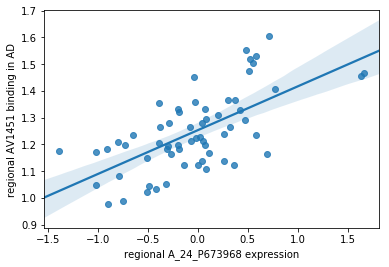



MACROD2 MACRO domain containing 2 r = 0.647067843655, FWE Q = 1.42011000665e-06


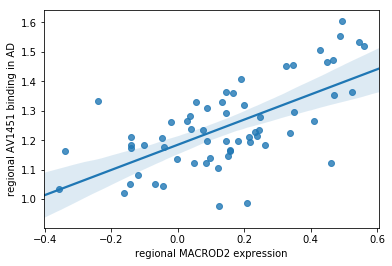



APOC1 apolipoprotein C-I r = 0.618361245723, FWE Q = 9.12759367036e-06


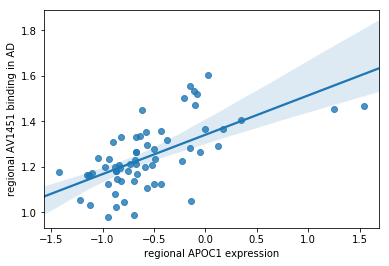



APOC1 apolipoprotein C-I r = 0.60873547821, FWE Q = 1.63480094262e-05


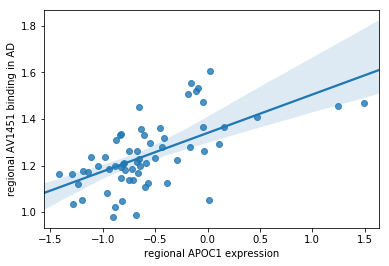



APOC1 apolipoprotein C-I r = 0.605183758982, FWE Q = 2.01719753885e-05


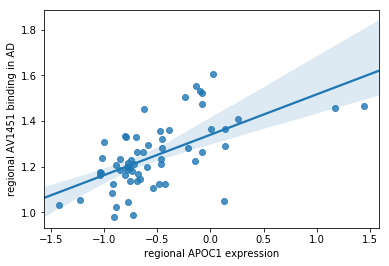



C1orf145 chromosome 1 open reading frame 145 r = 0.600840351313, FWE Q = 2.59942617286e-05


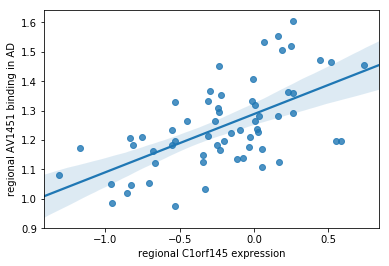



APOC4 apolipoprotein C-II r = 0.596005608676, FWE Q = 3.43209977017e-05


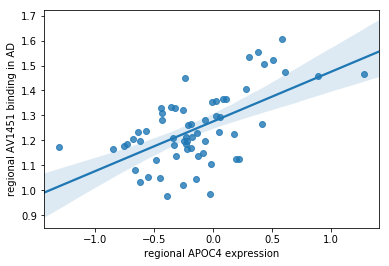



PYDC1 PYD (pyrin domain) containing 1 r = 0.566293060291, FWE Q = 0.000172069051057


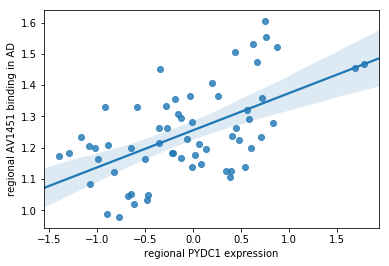



ARID5B AT rich interactive domain 5B (MRF1-like) r = -0.535668464107, FWE Q = 0.000775060144388


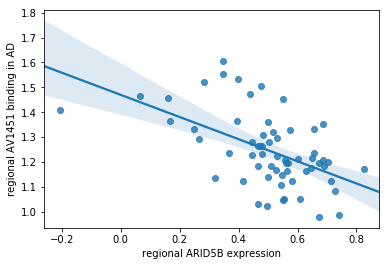



DPY19L1 dpy-19-like 1 (C. elegans) r = -0.535030873913, FWE Q = 0.000798492580368


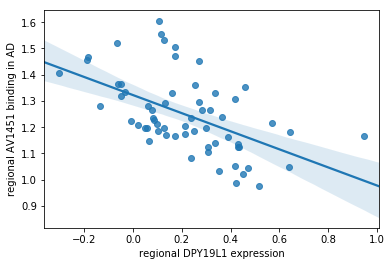



PTGER3 prostaglandin E receptor 3 (subtype EP3) r = 0.514734663244, FWE Q = 0.00199825765664


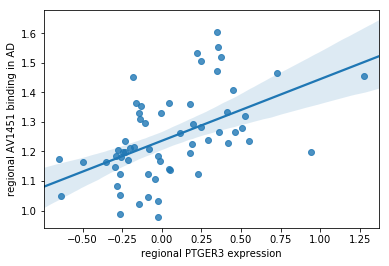



DPY19L1 dpy-19-like 1 (C. elegans) r = -0.482070073167, FWE Q = 0.00777679081359


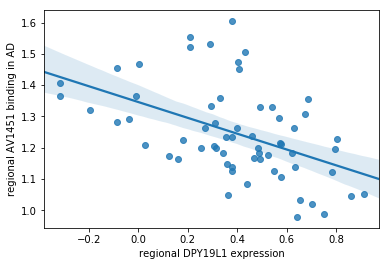



DPY19L1 dpy-19-like 1 (C. elegans) r = -0.472822298131, FWE Q = 0.01115020011


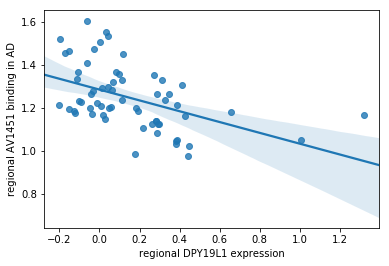



PTPRR protein tyrosine phosphatase, receptor type, R r = 0.439398752792, FWE Q = 0.0377624239441


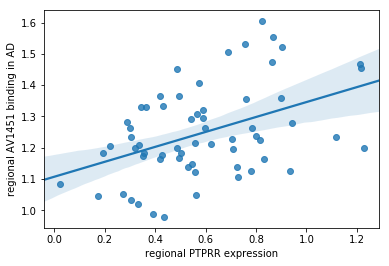



CRYBB1 crystallin, beta B1 r = -0.433762561526, FWE Q = 0.0458304776765


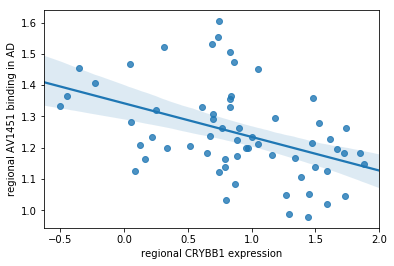

In [347]:
Ch3_TAU_results = pandas.DataFrame(index = Ch3_DKT.index, columns = ['t','p','gene_name'])
for gene in Ch3_DKT.index:
    g_name = probes.loc[gene]['gene_symbol']
    r, p = stats.pearsonr(Ch3_DKT.loc[gene].values,
                         Cad_DKT.mean().values)
    Ch3_TAU_results.loc[gene] = [r,p,g_name]
Ch3_TAU_results.loc[:,'Q_hs'] = multipletests(Ch3_TAU_results.p)[1]
Ch3_TAU_results.loc[:,'Q_bh'] = multipletests(Ch3_TAU_results.p, method = 'fdr_bh')[1]
Ch3_TAU_results.loc[:,'Q_bonf'] = multipletests(Ch3_TAU_results.p, method = 'bonferroni')[1]
for i,row in Ch3_TAU_results.sort_values('Q_bonf').iterrows():
    if row['Q_bonf'] < 0.05:
        print(row['gene_name'],probes.loc[i,'gene_name'], 'r = %s, FWE Q = %s'%(row['t'],row['Q_bonf']))
        plt.close()
        sns.regplot(Ch3_DKT.loc[i].values,
                   Cad_DKT.mean().values)
        plt.xlabel('regional %s expression'%(row['gene_name']))
        plt.ylabel('regional AV1451 binding in AD')
        plt.show()
        print('\n')

10 positive associated, 5 negatively associated

A_32_P215669 r = 0.579979089717, FWE Q = 8.04001161853e-05


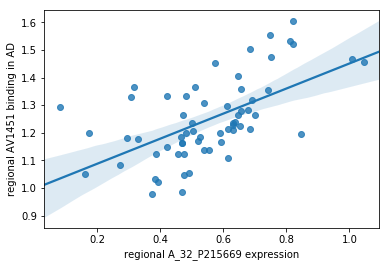



A_24_P924301 r = 0.574810855948, FWE Q = 0.000106038976115


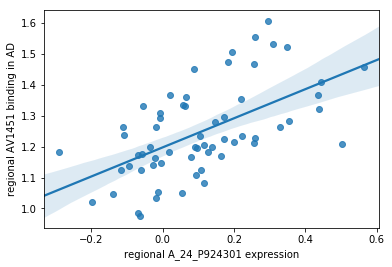



SDK1 r = -0.493992617321, FWE Q = 0.00463212396998


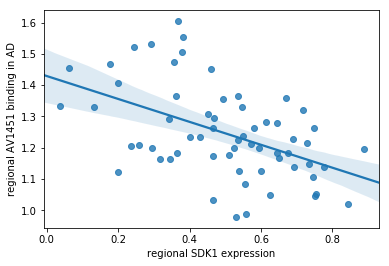



GRIA1 r = 0.493138393119, FWE Q = 0.00479705851154


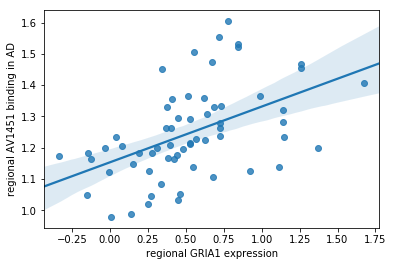



NPTXR r = 0.491899421368, FWE Q = 0.00504593988068


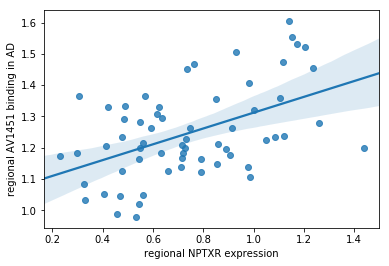



RAP2B r = 0.484315985999, FWE Q = 0.00684809661175


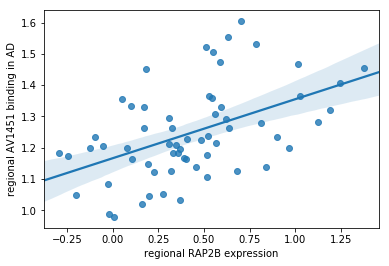



GALNTL4 r = 0.481645767514, FWE Q = 0.00761258221873


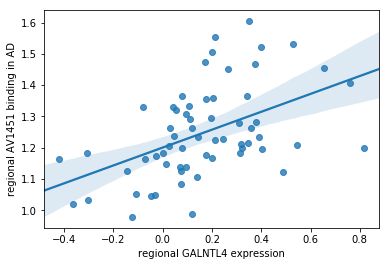



ABI1 r = 0.455772325449, FWE Q = 0.0203136989013


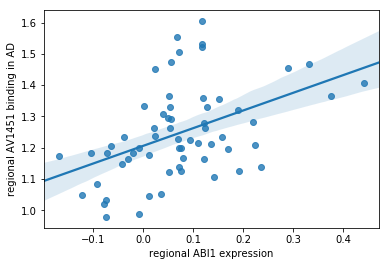



CELF3 r = 0.445061623659, FWE Q = 0.0298223607936


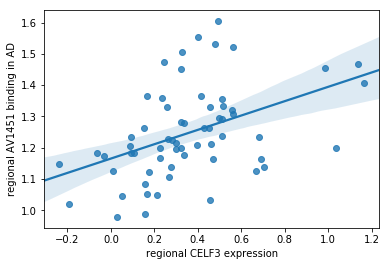



FLJ23867 r = -0.44326458631, FWE Q = 0.0317677177333


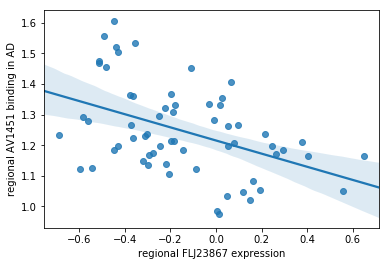

In [346]:
Ch1_TAU_results = pandas.DataFrame(index = Ch1_DKT.index, columns = ['t','p','gene_name'])
for gene in Ch1_DKT.index:
    g_name = probes.loc[gene]['gene_symbol']
    r, p = stats.pearsonr(Ch1_DKT.loc[gene].values,
                         Cad_DKT.mean().values)
    Ch1_TAU_results.loc[gene] = [r,p,g_name]
Ch1_TAU_results.loc[:,'Q_hs'] = multipletests(Ch1_TAU_results.p)[1]
Ch1_TAU_results.loc[:,'Q_bh'] = multipletests(Ch1_TAU_results.p, method = 'fdr_bh')[1]
Ch1_TAU_results.loc[:,'Q_bonf'] = multipletests(Ch1_TAU_results.p, method = 'bonferroni')[1]
for i,row in Ch1_TAU_results.sort_values('Q_bonf').iterrows():
    if row['Q_bonf'] < 0.05:
        print(row['gene_name'], 'r = %s, FWE Q = %s'%(row['t'],row['Q_bonf']))
        plt.close()
        sns.regplot(Ch1_DKT.loc[i].values,
                   Cad_DKT.mean().values)
        plt.xlabel('regional %s expression'%(row['gene_name']))
        plt.ylabel('regional AV1451 binding in AD')
        plt.show()
        print('\n')

8 positive associated, 2 negatively associated

### repeat with spearmanr

In [356]:
stats.rankdata?

APOC1 apolipoprotein C-I r = 0.64684848027, FWE Q = 1.44151480145e-06


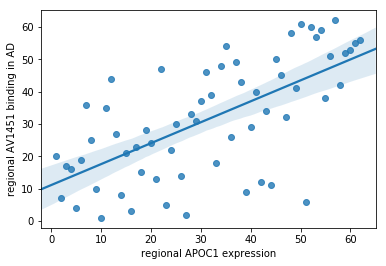



APOC1 apolipoprotein C-I r = 0.615975422427, FWE Q = 1.05653337902e-05


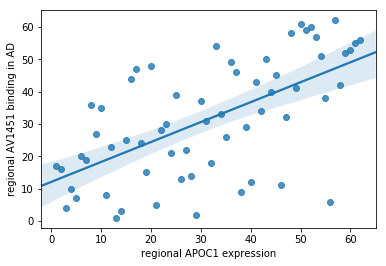



A_24_P673968 AGILENT probe A_24_P673968 (non-RefSeq) r = 0.612399587016, FWE Q = 1.3125418999e-05


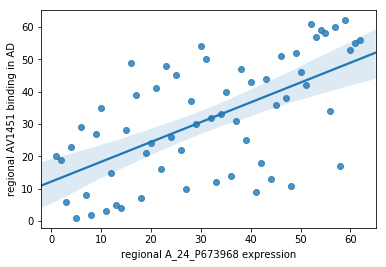



MACROD2 MACRO domain containing 2 r = 0.597240059429, FWE Q = 3.19841313398e-05


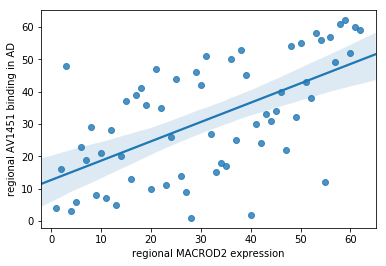



APOC1 apolipoprotein C-I r = 0.59718969555, FWE Q = 3.20764682945e-05


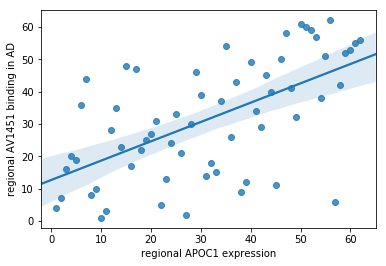



C1orf145 chromosome 1 open reading frame 145 r = 0.588124197326, FWE Q = 5.34690909086e-05


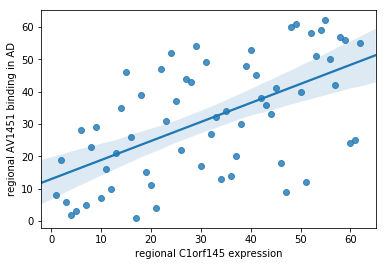



DPY19L1 dpy-19-like 1 (C. elegans) r = -0.568885195538, FWE Q = 0.000150429379236


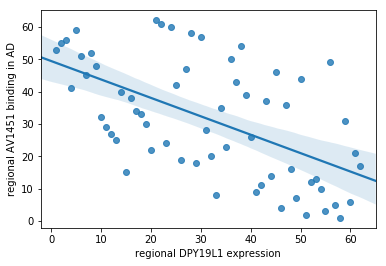



PTGER3 prostaglandin E receptor 3 (subtype EP3) r = 0.555891314749, FWE Q = 0.000291753532488


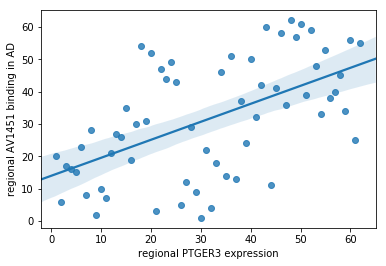



ARID5B AT rich interactive domain 5B (MRF1-like) r = -0.535947218655, FWE Q = 0.000765018145955


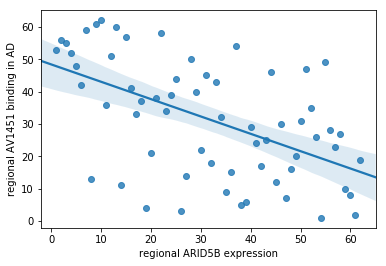



PYDC1 PYD (pyrin domain) containing 1 r = 0.529299186623, FWE Q = 0.0010408389535


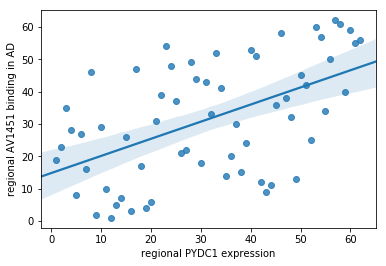



APOC4 apolipoprotein C-II r = 0.511319281811, FWE Q = 0.00231854564013


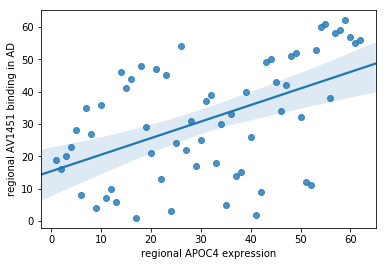



DPY19L1 dpy-19-like 1 (C. elegans) r = -0.50411724711, FWE Q = 0.00315584495175


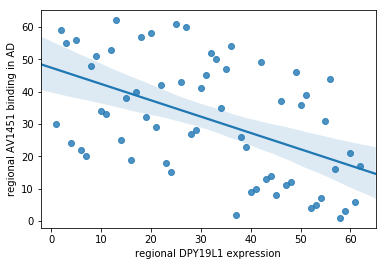



DPY19L1 dpy-19-like 1 (C. elegans) r = -0.498073581627, FWE Q = 0.00406606789946


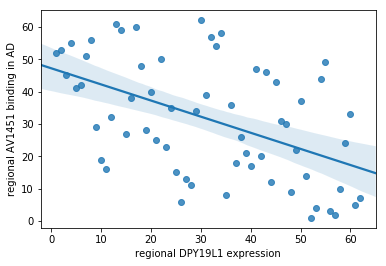



AKAP12 A kinase (PRKA) anchor protein 12 r = -0.460351036237, FWE Q = 0.0178384594218


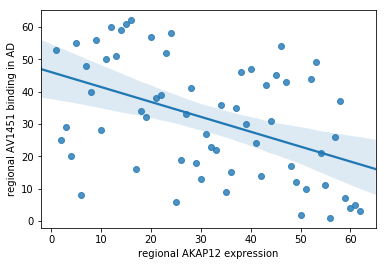



CRYBB1 crystallin, beta B1 r = -0.448162977513, FWE Q = 0.027756677065


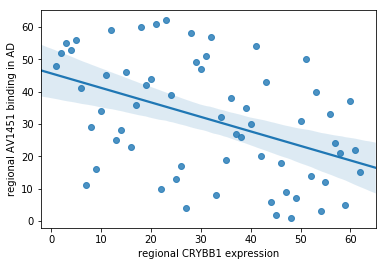



CNTN4 contactin 4 r = -0.447659338722, FWE Q = 0.028258429127


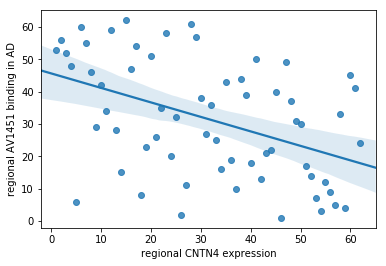



C21orf62 chromosome 21 open reading frame 62 r = 0.447105336053, FWE Q = 0.0288199164568


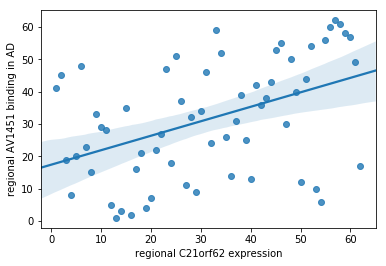



NDST4 N-deacetylase/N-sulfotransferase (heparan glucosaminyl) 4 r = 0.434464002417, FWE Q = 0.0447473877685


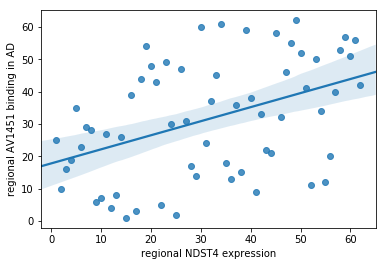

In [358]:
npCh3_TAU_results = pandas.DataFrame(index = Ch3_DKT.index, columns = ['t','p','gene_name'])
for gene in Ch3_DKT.index:
    g_name = probes.loc[gene]['gene_symbol']
    r, p = stats.spearmanr(Ch3_DKT.loc[gene].values,
                         Cad_DKT.mean().values)
    npCh3_TAU_results.loc[gene] = [r,p,g_name]
npCh3_TAU_results.loc[:,'Q_hs'] = multipletests(npCh3_TAU_results.p)[1]
npCh3_TAU_results.loc[:,'Q_bh'] = multipletests(npCh3_TAU_results.p, method = 'fdr_bh')[1]
npCh3_TAU_results.loc[:,'Q_bonf'] = multipletests(npCh3_TAU_results.p, method = 'bonferroni')[1]
for i,row in npCh3_TAU_results.sort_values('Q_bonf').iterrows():
    if row['Q_bonf'] < 0.05:
        print(row['gene_name'],probes.loc[i,'gene_name'], 'r = %s, FWE Q = %s'%(row['t'],row['Q_bonf']))
        plt.close()
        sns.regplot(stats.rankdata(Ch3_DKT.loc[i].values),
                   stats.rankdata(Cad_DKT.mean().values))
        plt.xlabel('regional %s expression'%(row['gene_name']))
        plt.ylabel('regional AV1451 binding in AD')
        plt.show()
        print('\n')

A_24_P924301 AGILENT probe A_24_P924301 (non-RefSeq) r = 0.604492458009, FWE Q = 2.02227377678e-05


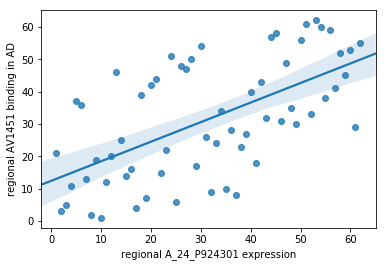



A_32_P215669 AGILENT probe A_32_P215669 (non-RefSeq) r = 0.602628994485, FWE Q = 2.25515954844e-05


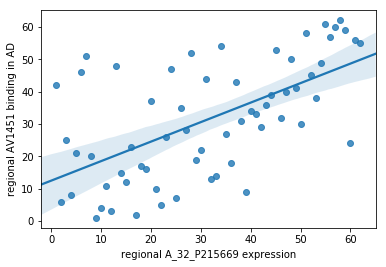



GRIA1 glutamate receptor, ionotropic, AMPA 1 r = 0.562237163506, FWE Q = 0.000203938034422


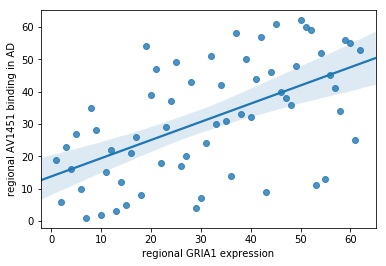



GALNTL4 UDP-N-acetyl-alpha-D-galactosamine:polypeptide N-acetylgalactosaminyltransferase-like 4 r = 0.51756440281, FWE Q = 0.00169857109303


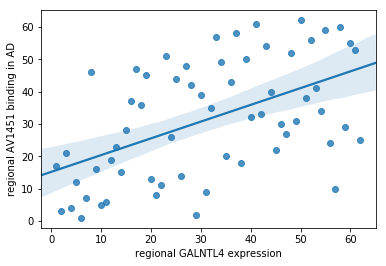



RAP2B RAP2B, member of RAS oncogene family r = 0.493490468636, FWE Q = 0.00472843288726


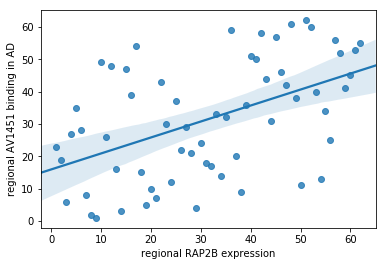



SDK1 sidekick cell adhesion molecule 1 r = -0.479942585178, FWE Q = 0.00814049311134


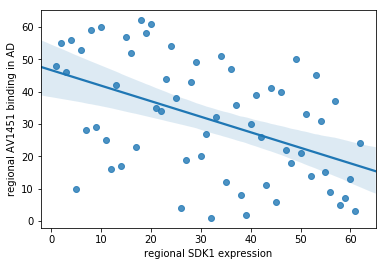



CELF3 CUGBP, Elav-like family member 3 r = 0.477071844073, FWE Q = 0.00910719730886


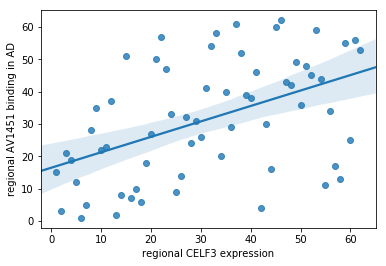



SLC24A3 solute carrier family 24 (sodium/potassium/calcium exchanger), member 3 r = 0.467502707058, FWE Q = 0.0131445088715


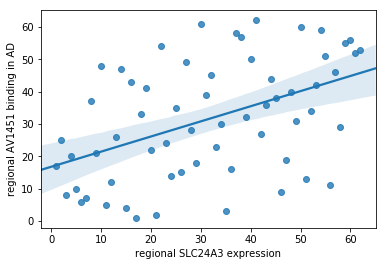



NPTXR neuronal pentraxin receptor r = 0.452292815593, FWE Q = 0.0230443326577


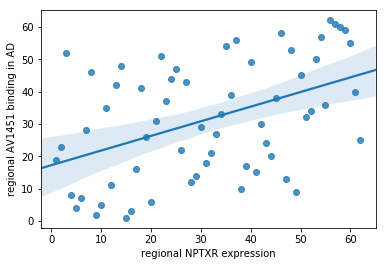



ABI1 abl-interactor 1 r = 0.440104756868, FWE Q = 0.0354712478258


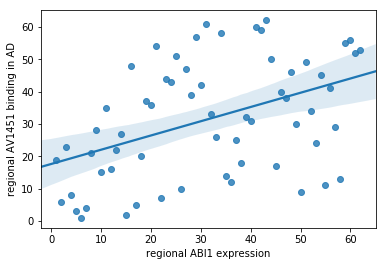



NT5DC3 5'-nucleotidase domain containing 3 r = 0.4301830727, FWE Q = 0.0498040571882


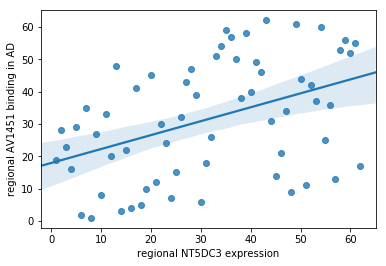

In [359]:
npCh1_TAU_results = pandas.DataFrame(index = Ch1_DKT.index, columns = ['t','p','gene_name'])
for gene in Ch1_DKT.index:
    g_name = probes.loc[gene]['gene_symbol']
    r, p = stats.spearmanr(Ch1_DKT.loc[gene].values,
                         Cad_DKT.mean().values)
    npCh1_TAU_results.loc[gene] = [r,p,g_name]
npCh1_TAU_results.loc[:,'Q_hs'] = multipletests(npCh1_TAU_results.p)[1]
npCh1_TAU_results.loc[:,'Q_bh'] = multipletests(npCh1_TAU_results.p, method = 'fdr_bh')[1]
npCh1_TAU_results.loc[:,'Q_bonf'] = multipletests(npCh1_TAU_results.p, method = 'bonferroni')[1]
for i,row in npCh1_TAU_results.sort_values('Q_bonf').iterrows():
    if row['Q_bonf'] < 0.05:
        print(row['gene_name'],probes.loc[i,'gene_name'], 'r = %s, FWE Q = %s'%(row['t'],row['Q_bonf']))
        plt.close()
        sns.regplot(stats.rankdata(Ch1_DKT.loc[i].values),
                   stats.rankdata(Cad_DKT.mean().values))
        plt.xlabel('regional %s expression'%(row['gene_name']))
        plt.ylabel('regional AV1451 binding in AD')
        plt.show()
        print('\n')

# THIS IS TOTALLY UNRELATED

In [365]:
ALL_DKT = pandas.DataFrame(index = bigdf.index, columns = ldf.label[:78])
for roi in ALL_DKT.columns:
    roi_cols = wbdf[wbdf.dkt_label==roi].index
    roi_xp = bigdf[bigdf.columns[roi_cols]]
    ALL_DKT.loc[:,roi] = roi_xp.mean(axis=1).values

In [366]:
ALL_DKT.shape

(58692, 78)

In [367]:
ALL_DKT.to_csv('DKT_gene_expression.csv')

In [368]:
del(bigdf)

In [369]:
ad_DKT = nsdf.loc[nsdf_ref[(nsdf_ref.DX_fill == 'Dementia') & (nsdf_ref.av45_status == 1)].index]
ad_DKT.drop(ad_DKT.columns[[33,72]],axis=1, inplace=True)
ALL_DKT.drop(ALL_DKT.columns[[33,72]],axis=1, inplace=True)
Cad_DKT = ad_DKT.drop(ad_DKT.columns[subcort],axis=1)
CALL_DKT = ALL_DKT.drop(ALL_DKT.columns[subcort],axis=1)

running PCA
transforming data
performing model cross-validation
using basic cross-validation


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not c

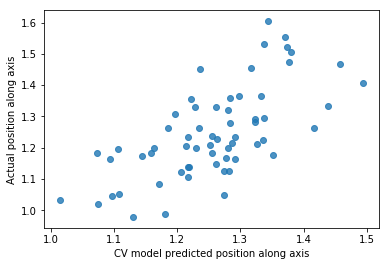

model cv score: r2 =  0.443720639746
running final model
final model fit r2 =  0.934409581983


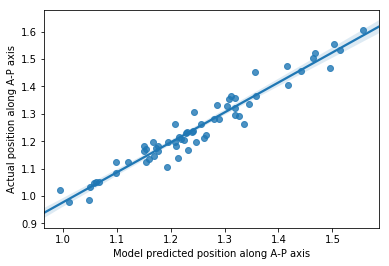

running sanity_check


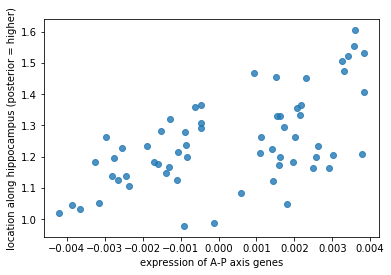

posterior 1 genes vs. y:  r2 = 0.348741635859, p = 4.36675498995e-07 




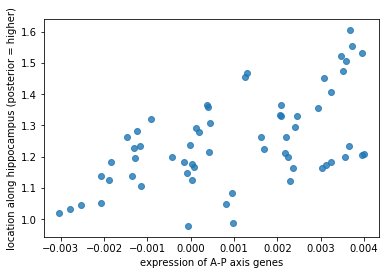

posterior 2 genes vs. y:  r2 = 0.311588607693, p = 2.428724746e-06 




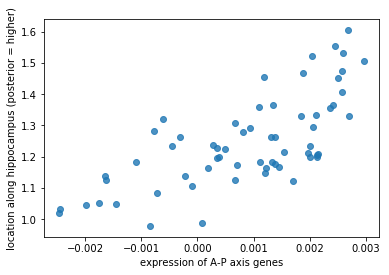

posterior 5 genes vs. y:  r2 = 0.496539937887, p = 1.6412950789e-10 




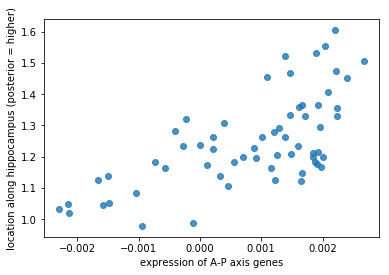

posterior 10 genes vs. y:  r2 = 0.437771408862, p = 4.77786063693e-09 




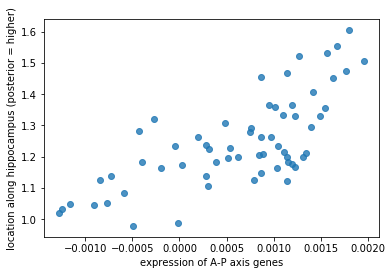

posterior 20 genes vs. y:  r2 = 0.515622312174, p = 5.05891466719e-11 




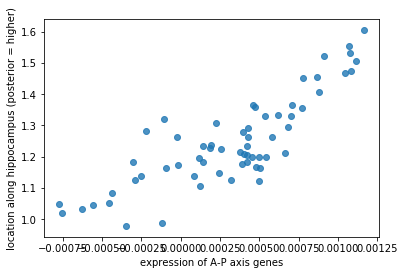

posterior 50 genes vs. y:  r2 = 0.694213175165, p = 4.46516243873e-17 




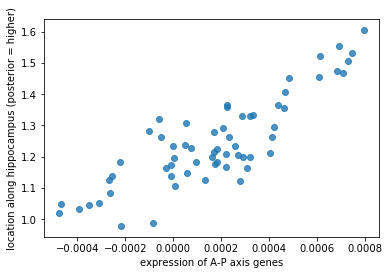

posterior 100 genes vs. y:  r2 = 0.725574782817, p = 1.70146447017e-18 




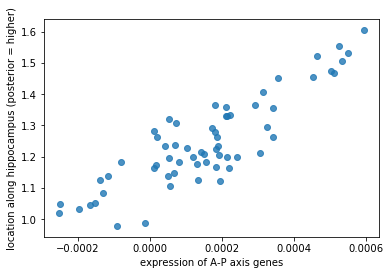

posterior 200 genes vs. y:  r2 = 0.760363430143, p = 2.85072913204e-20 




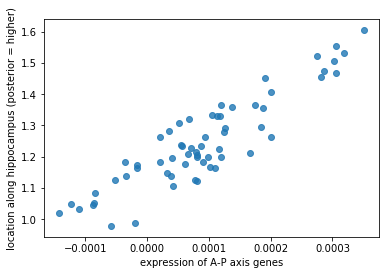

posterior 500 genes vs. y:  r2 = 0.814939245845, p = 1.18398250515e-23 




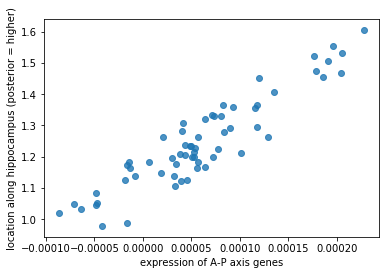

posterior 1000 genes vs. y:  r2 = 0.850423992131, p = 1.95376183778e-26 




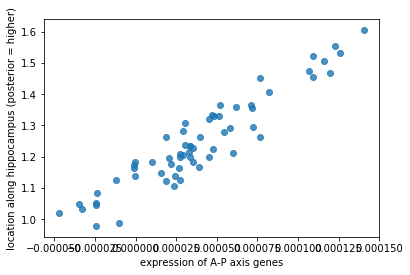

posterior 2000 genes vs. y:  r2 = 0.880360305693, p = 2.36611914484e-29 




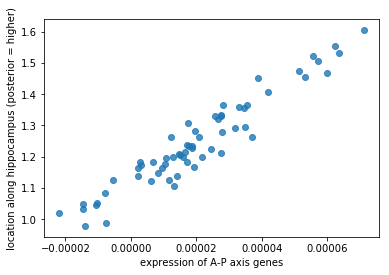

posterior 5000 genes vs. y:  r2 = 0.914906413369, p = 8.44544112365e-34 




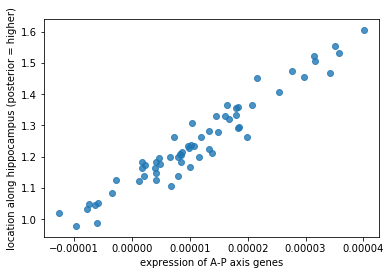

posterior 10000 genes vs. y:  r2 = 0.93474683018, p = 2.90581985981e-37 




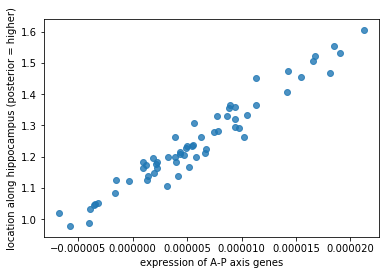

posterior 20000 genes vs. y:  r2 = 0.941186133422, p = 1.28284000828e-38 




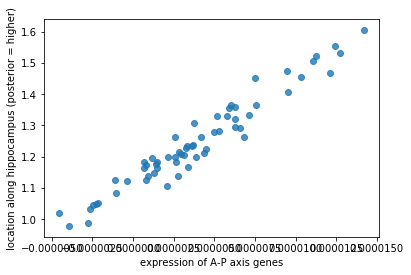

posterior 30000 genes vs. y:  r2 = 0.941577203895, p = 1.04993776313e-38 




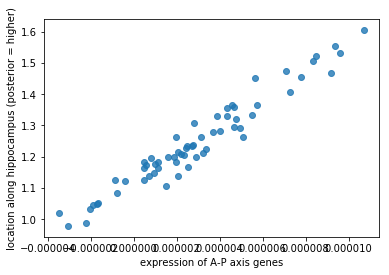

posterior 40000 genes vs. y:  r2 = 0.941714378291, p = 9.78376129608e-39 




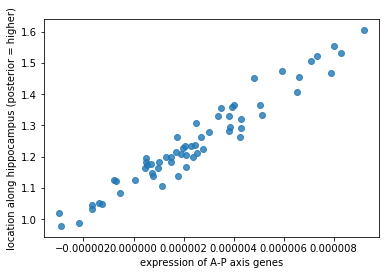

posterior 50000 genes vs. y:  r2 = 0.940664290738, p = 1.67255727497e-38 




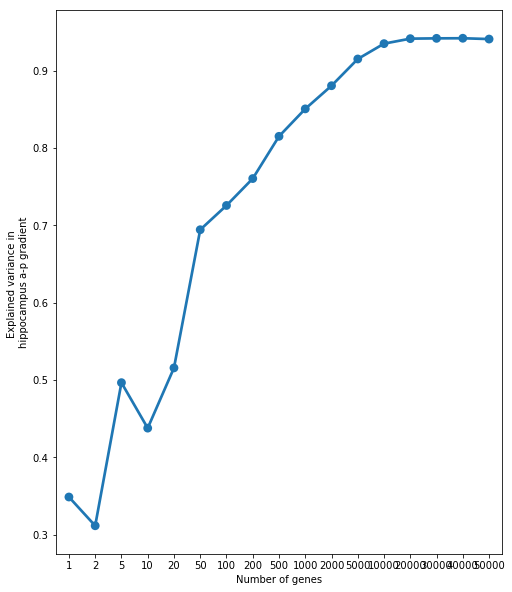

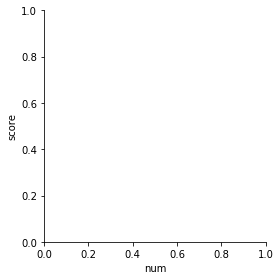

In [372]:
pcalr_out_NEW2 = PCA_LR_pipeline(CALL_DKT.values.T, Cad_DKT.mean(), 
                            cv_strategy='score', illustrative=True,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000,
                                           10000, 20000, 30000, 40000, 50000 ],
                               sanity_check_style = 'model')

In [383]:
[x for x in probes.index if probes.loc[x,'gene_symbol'] == 'MAPT']

[34900, 40055, 42057, 43534]

In [382]:
[x for x in probes.index if probes.loc[x,'gene_symbol'] == 'MAPT']

SyntaxError: invalid syntax (<ipython-input-382-97e22321f450>, line 1)

In [384]:
[pcalr_out_NEW2['betas'][x] for x in [x for x in probes.index if probes.loc[x,'gene_symbol'] == 'MAPT']]

[6.5215082720733792e-05,
 2.6454960624416006e-05,
 0.00015784166047172726,
 0.00017449883504348066]

In [386]:
probes.loc[pcalr_out_NEW2['gene_selections']['posterior_genes_50']]['gene_symbol'].tolist()[::-1]

['CD70',
 'MGP',
 'EXD1',
 'AC016683.6',
 'FOXD4L3',
 'PDYN',
 'A_32_P3431',
 'A_24_P788227',
 'A_23_P306240',
 'SLC22A10',
 'FAM20A',
 'GLP2R',
 'CD244',
 'A_24_P673968',
 'PDYN',
 'LHX9',
 'GPR6',
 'DUXAP10',
 'PDYN',
 'KCTD4',
 'SLC22A9',
 'A_32_P16323',
 'CARTPT',
 'PDYN',
 'PDYN',
 'FHAD1',
 'LIPH',
 'PDYN',
 'C6ORF141',
 'PDYN',
 'BDKRB2',
 'KCTD4',
 'A_32_P47778',
 'MYBPC1',
 'PKD2L1',
 'MYBPC1',
 'LIPH',
 'KLK8',
 'A_24_P563736',
 'MSC',
 'CARTPT',
 'MET',
 'CARTPT',
 'CARTPT',
 'CARTPT',
 'CARTPT',
 'CARTPT',
 'CARTPT',
 'MET',
 'MET']

In [389]:
allres = pandas.DataFrame(index = CALL_DKT.index, columns = ['r','p'])
for i,gene in enumerate(allres.index):
    r, p = stats.pearsonr(CALL_DKT.loc[gene].values,
                         Cad_DKT.mean().values)
    allres.loc[gene] = [r,p]
    if i%5000 == 0:
        print('finished',i)

finished 0
finished 5000
finished 10000
finished 15000
finished 20000
finished 25000
finished 30000
finished 35000
finished 40000
finished 45000
finished 50000
finished 55000


In [390]:
allres.loc[[x for x in probes.index if probes.loc[x,'gene_symbol'] == 'MAPT']]

,r,p
34900,0.485125,6.43779e-05
40055,0.00433779,0.973307
42057,0.142687,0.268585
43534,0.0843633,0.514451


In [393]:
allres.loc[:,'gene_name'] = probes.loc[:,'gene_name']
allres.loc[:,'gene_symbol'] = probes.loc[:,'gene_symbol']

In [394]:
allres.sort_values('r')

,r,p,gene_name,gene_symbol
58161,-0.772628,1.90159e-13,AGILENT probe A_24_P564761 (non-RefSeq),A_24_P564761
9472,-0.745457,3.65838e-12,receptor (G protein-coupled) activity modifyin...,RAMP3
42730,-0.710118,1.02445e-10,neuregulin 1,NRG1
55593,-0.701379,2.16653e-10,AGILENT probe A_32_P171427 (non-RefSeq),A_32_P171427
23521,-0.700335,2.36509e-10,heparan sulfate (glucosamine) 3-O-sulfotransfe...,HS3ST5
27029,-0.696937,3.1382e-10,oxysterol binding protein-like 3,OSBPL3
8107,-0.691184,5.02145e-10,"purinergic receptor P2X, ligand-gated ion chan...",P2RX6
23256,-0.686588,7.25382e-10,5'-nucleotidase domain containing 1,NT5DC1
34958,-0.668732,2.84777e-09,neuregulin 1,NRG1
27030,-0.666503,3.35587e-09,oxysterol binding protein-like 3,OSBPL3


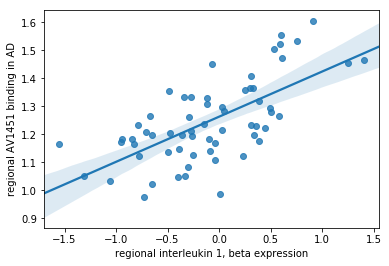

In [398]:
g = 3038
plt.close()
sns.regplot(CALL_DKT.loc[g].values,
            Cad_DKT.mean().values)
plt.xlabel('regional %s expression'%(allres.loc[g,'gene_name']))
plt.ylabel('regional AV1451 binding in AD')
plt.show()


In [ ]:
h1_TAU_results.loc[:,'Q_hs'] = multipletests(h1_TAU_results.p)[1]
h1_TAU_results.loc[:,'Q_bh'] = multipletests(h1_TAU_results.p, method = 'fdr_bh')[1]
h1_TAU_results.loc[:,'Q_bonf'] = multipletests(h1_TAU_results.p, method = 'bonferroni')[1]

In [371]:
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import model_selection
def PCA_LR_pipeline(in_mtx, y, pca = PCA(random_state=123), 
                    clf = linear_model.LassoCV(random_state = 123), 
                    cv_strategy = None, cv = 10, test_gene_num = [100], illustrative = False,
                   sanity_check_style = 'separate', cv_labels = []):
    
    final_outputs = {}
    
    if type(in_mtx) == pandas.core.frame.DataFrame:
        in_mtx = in_mtx.values
    
    if type(pca) == type(None):
        pca_tfm = in_mtx
    else:
        print('running PCA')
        dat_pca = pca.fit(in_mtx)
        print('transforming data')
        pca_tfm = dat_pca.transform(in_mtx)
        if len(y) != pca_tfm.shape[-1]:
            raise ValueError('length of y-axis of transformed item must match the length of y')
        final_outputs.update({'pca_object': dat_pca})
    
    
    print('performing model cross-validation')
    if hasattr(cv_strategy, 'get_n_splits'):
        folds = cv_strategy.get_n_splits(pca_tfm)
        #scores = model_selection.cross_val_score(clf, pca_tfm, y=y, groups=folds, cv=cv)
        predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, groups=folds, cv=cv)
        observed = y
        score = stats.pearsonr(predicted, y)[0]**2
    elif cv_strategy == 'LOLO':
        print('using leave-one-label-out cross-validation')
        observed, predicted = leave_one_x_out(cv_labels, pca_tfm, y, clf)
        score = stats.pearsonr(predicted,observed)[0]**2
    elif cv_strategy == 'balanced':
        print('balancing cross-validation by labels')
        observed, predicted = balanced_cv(cv_labels, pca_tfm, y, clf, cv)
        score = stats.pearsonr(predicted,observed)[0]**2
    elif type(cv_strategy) != type(None):
        print('using basic cross-validation')
        #scores = model_selection.cross_val_score(clf, pca_tfm, y=y, cv=cv)
        predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, cv=cv)
        observed = y
        score = stats.pearsonr(predicted, y)[0]**2
    else:
        score = None
    if type(score) != type(None):
        if illustrative:
            plt.close()
            sns.regplot(predicted, observed, fit_reg=False)
            plt.xlabel('CV model predicted position along axis')
            plt.ylabel('Actual position along axis')
            plt.show()
        print('model cv score: r2 = ',score)
        final_outputs.update({'CV_scores': score})
    else:
        print('no valid cross-validation method specified')
    
    print('running final model')
    mod = clf.fit(pca_tfm, y)
    if not hasattr(mod,'coef_'):
        raise IOError('right now, this pipeline can only accept clf objects with a coef_ attribute')
    final_outputs.update({'final_model': mod})
    scr = mod.score(pca_tfm, y)
    print('final model fit r2 = ',scr)
    if illustrative:
        plt.close()
        sns.regplot(x=mod.predict(pca_tfm), y=y)
        plt.xlabel('Model predicted position along A-P axis')
        plt.ylabel('Actual position along A-P axis')
        plt.show()
    
    if type(pca) == type(None):
        f_betas = mod.coef_
    else:
        f_betas = back_transform(dat_pca, mod)
    final_outputs.update({'betas': f_betas})
    
    gene_selections = sanity_check(in_mtx, y, f_betas, test_gene_num, 
                                   illustrative, sanity_check_style)
    final_outputs.update({'gene_selections': gene_selections})
    
    return final_outputs
    
def back_transform(pca_obj, clf_obj):
    return np.dot(pca_obj.components_.T,clf_obj.coef_)

def sanity_check(in_mtx, y, betas, test_gene_num, illustrative, sanity_check_style):
    
    if sanity_check_style == 'separate':
        ascores = []
        pscores = []
    else:
        scores = []
    print('running sanity_check')
    betas = pandas.Series(betas)
    outputs = {}
    for num in test_gene_num:
      
        p_chk = betas.sort_values(ascending=False)[:num].index
        a_chk = betas.sort_values(ascending=False)[-num:].index

        pchk_vals = []
        achk_vals = []
        
        for sample in range(in_mtx.shape[0]):
            to_avg = []
            for gene in p_chk:
                to_avg.append(in_mtx[sample,gene])
            if sanity_check_style == 'model':
                pchk_vals.append(np.mean(np.array(to_avg) * betas.loc[p_chk].values))
            else:
                pchk_vals.append(np.mean(to_avg))
        
        for sample in range(in_mtx.shape[0]):
            to_avg = []
            for gene in a_chk:
                to_avg.append(in_mtx[sample,gene])
            if sanity_check_style == 'separate':
                achk_vals.append(np.mean(to_avg))
            elif sanity_check_style == 'model':
                achk_vals.append(np.mean(np.array(to_avg) * betas.loc[a_chk].values))
            else:
                achk_vals.append(np.mean(to_avg) * -1)

        if sanity_check_style != 'separate':
            chk_vals = np.array(pchk_vals) + np.array(achk_vals)
            
        if sanity_check_style == 'separate':
            pr,pp = stats.pearsonr(pchk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(pchk_vals), y=y, fit_reg=None)
                plt.xlabel('expression of posterior direction genes')
                plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
            print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, pr**2, pp))

            ar,ap = stats.pearsonr(achk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(achk_vals), y=y, fit_reg=None)
                plt.xlabel('expression of anterior direction genes')
                plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
            print('anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, ar**2, ap))
            
        else:
            r,p = stats.pearsonr(chk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(chk_vals), y=y, fit_reg=None)
                plt.xlabel('expression of A-P axis genes')
                plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
            print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, r**2, p))
            
        if sanity_check_style == 'separate':
            ascores.append(ar**2)
            pscores.append(pr**2)
        else:
            scores.append(r**2)
        outputs.update({'posterior_genes_%s'%num: p_chk}) 
        outputs.update({'anterior_genes_%s'%num: a_chk})
            
    if len(test_gene_num) > 1:
        if sanity_check_style == 'separate':
            jnk = pandas.concat([pandas.Series(test_gene_num), 
                                 pandas.Series(ascores),
                                pandas.Series(pscores)],axis=1)
            jnk.columns = ['num','a','p']

            plt.close()
            fig,(ax1,ax2) = plt.subplots(2, figsize=(8,10))
            sns.factorplot(x='num', y='a', data=jnk, ax=ax1)
            sns.factorplot(x='num', y='p', data=jnk, ax=ax2)
            ax1.set(xlabel = 'Number of posterior genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            ax2.set(xlabel = 'Number of anterior genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            plt.show()
        else:
            jnk = pandas.concat([pandas.Series(test_gene_num), 
                                 pandas.Series(scores)
                                ],axis=1)
            jnk.columns = ['num','score']

            plt.close()
            fig,ax1 = plt.subplots(1, figsize=(8,10))
            sns.factorplot(x='num', y='score', data=jnk, ax=ax1)
            ax1.set(xlabel = 'Number of genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            plt.show()

    return outputs

def leave_one_x_out(labels, in_X, in_y, clf):

    obsz = []
    predz = []
    label_map = dict(zip(labels.unique(), range(len(labels.unique()))))
    labels = [label_map[x] for x in labels]
    for label in np.unique(labels):
        Tr_samps = [i for i in labels if labels[i] != label]
        Te_samps = [i for i in labels if labels[i] == label]
        X = in_X[Tr_samps,:]
        in_y = y.iloc[Tr_samps]
        mod = clf.fit(X,y)
        pred = mod.predict(in_X[Te_samps,:])
        for x in range(len(pred)):
            obsz.append(y.values[x])
            predz.append(pred[x])
    
    return obsz, predz

def balanced_cv(labels, in_X, in_y, clf, cv):
    
    obsz = []
    predz = []
    tst = model_selection.StratifiedKFold(n_splits=cv, random_state=123)
    label_map = dict(zip(labels.unique(), range(len(labels.unique()))))
    labels = [label_map[x] for x in labels]
    for tr_idx, te_idx in tst.split(in_X, labels):
        X = in_X[tr_idx,:]
        y = in_y.loc[tr_idx]
        mod = clf.fit(X,y)
        pred = mod.predict(in_X[te_idx,:])
        for i in range(len(predz)):
            obsz.append(y.values[x])
            predz.append(pred[i])
            
    return obsz, predz